overall, using K's architecture instead of local PCN, we can achieve same type qualitative conclusions: more cycles -> better performance.

In [1]:
from sys import path
from os.path import relpath, realpath, abspath, join, exists
from itertools import product, chain

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py

pd.set_option('display.max_rows', 999)

In [2]:
from torchnetjson.builder import build_net

In [3]:
from thesis_v2 import dir_dict
from thesis_v2.data import load_data_helper
from thesis_v2.training.training_aux import load_training_results
# I forgot how this count_params handles BN buffer parameters (running mean and std) looks like it's ignored.
from thesis_v2.training_extra.misc import count_params
from thesis_v2.models.maskcnn_polished_with_rcnn_k_bl.builder import load_modules

load_modules()

In [4]:
from thesis_v2.configs.model.maskcnn_polished_with_rcnn_k_bl import (
    explored_models_20200518_gaya as param_iterator_obj,
    keygen
)

In [5]:
def load_everything():
    _df_collect = []
    for idx, param in enumerate(
        chain(
            param_iterator_obj().generate(),
#             param_iterator_obj_smaller_training_data().generate()
        )
    ):
        if idx % 100 == 0:
            print(idx)
            
#         if idx >= 100:
#             break
            
#         print(len(param))
#         print(len(param))

        assert param['kernel_size_l23'] == 3
        assert len(param) == 24
        
        assert param['kernel_size_l1'] == 9
        assert param['ff_1st_block']
        
        
        
        assert param['split_seed'] == 'legacy'
        assert param['pooling_ksize'] == 3
        assert param['pooling_type'] == 'avg'
        assert not param['bn_after_fc']
        assert param['rcnn_bl_psize'] == 1
        assert param['rcnn_bl_ptype'] is None
        assert param['input_size'] == 63
        
        # 12 to go
        # remove smoothness_name and scale_name, 10 to go
        
#         assert param['model_seed'] == 0
        
        key = keygen(**{k: v for k, v in param.items() if k not in {'scale', 'smoothness'}})
        # 10 to go.
        result = load_training_results(key, return_model=False)
        # load twice, first time to get the model.
        result = load_training_results(key, return_model=True, model=build_net(result['config_extra']['model']))
        num_epochs = [len(x) for x in result['stats_all']]
        
        cc_raw = np.asarray(result['stats_best']['stats']['test']['corr'])
        assert cc_raw.shape == (14,)
        
        _df_collect.append(
            {
                'train_keep': param['train_keep'],
                'act_fn': param['act_fn'],
                'loss_type': param['loss_type'],
                'scale': float(param['scale']),
                'smoothness': float(param['smoothness']),
                'num_layer': param['num_layer'],
                'out_channel': param['out_channel'],
                # 4 to go.
                '1st_bn_before_act': param['ff_1st_bn_before_act'],
                'rcnn_bl_cls': param['rcnn_bl_cls'],
                'rcnn_acc_type': param['rcnn_acc_type'],

                'model_seed': param['model_seed'],
                # done,
                'corr_test': cc_raw.mean(),
                'max_epoch': max(num_epochs),
                'num_param': count_params(result['model']),
            }
        )
    _df =  pd.DataFrame(_df_collect, columns=[
#             'split_seed',
        'train_keep',
        'act_fn',
        'loss_type', 'scale', 'smoothness', 'num_layer',
        'out_channel', '1st_bn_before_act',

        'rcnn_bl_cls',
#         'rcnn_acc_type',
        'model_seed',

        'corr_test',
        'num_param',
        'max_epoch',
    ])
#     print(_df)
    _df = _df.set_index([
        'train_keep',
        'act_fn',
        'loss_type', 'scale', 'smoothness', 'num_layer',
        'out_channel', '1st_bn_before_act',
        'rcnn_bl_cls',
#         'rcnn_acc_type',
        'model_seed',
    ], verify_integrity=True)
    return _df

In [6]:
df = load_everything()

0
100
200
300
400
500
600
700


In [7]:
corr_mean = df['corr_test'].unstack('model_seed').mean(axis=1)

# mean, max, min, all the same. for num_param
num_param = df['num_param'].unstack('model_seed').mean(axis=1)

In [8]:
# let's try to quickly eliminate bad configs, just like before, by plotting scatter plots.
def scatter(x, y, xlabel, ylabel, title):
    plt.close('all')
    plt.figure(figsize=(6, 5))
    plt.scatter(x, y, s=1)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.axis('equal')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.plot([0,1],[0,1],linestyle='--')
    plt.title(title)
    plt.show()
    print('y-x mean', (y-x).mean(), 'y-x>0 mean', ((y-x)>0).mean())
    print('y top', y.max(), 'x top', x.max())

In [9]:
# here, I need to check the effective ness of act_fn, bn_before_act, bn_after_fc, loss_type
def check_compare_one_case(series_in, label_to_unstack, values_to_check=None):
    df_unstacked = series_in.unstack(label_to_unstack)
#     assert df_unstacked.shape[1] == 2
    if values_to_check is None:
        values_to_check = df_unstacked.columns.values[:2].tolist()
    else:
        pass
    
    assert len(values_to_check) == 2
    label_x = values_to_check[0]
    label_y = values_to_check[1]
        
    data_x = df_unstacked.loc[:,label_x].values
    data_y = df_unstacked.loc[:,label_y].values
    
    
    
    scatter(data_x, data_y, str(label_x), str(label_y), f'{label_to_unstack}: {label_y} vs {label_x}')

(48, 4)
[1, 2, 3, 4]
n 48
2 - 1 mean 0.03860639191712006 sem 0.0050401476989623785
3 - 2 mean 0.007477586930649122 sem 0.0026956045846909167
4 - 3 mean 0.006941637598295812 sem 0.0020583813932118374
4 - 2 mean 0.014419224528944933 sem 0.0034240826002208897


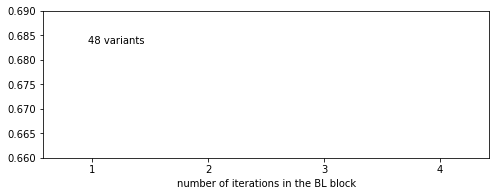

[0.5345164084682384, 0.5731228003853587, 0.5806003873160077, 0.5875420249143036] [7.22267667 1.30470938 1.19559645]


,num_of_cycles,performance,gain %
0,1,0.534516,NaN
1,2,0.573123,7.222677
2,3,0.580600,1.304709
3,4,0.587542,1.195596


In [10]:
def plot_step_increase(df_this, pairs_to_check, ylim):
    # remove those no innner act ones.
    df_unstacked = df_this.unstack('rcnn_bl_cls')
#     df_unstacked = corr_mean.unstack('pcn_cls')
    print(df_unstacked.shape)
    
#     selector = df_unstacked.values[:,0] >= 0.50
    selector = ()
#     print(selector.mean())
    
    cls_values = df_unstacked.columns.values.tolist()
    print(cls_values)
    assert cls_values == list(range(1,len(cls_values)+1))
    
    n = df_unstacked.shape[0]
    
#     n = selector.sum()
    print('n', n)
    
    
    for p1, p2 in pairs_to_check:
        val0 = df_unstacked.values[:,p1-1][selector]
        val1 = df_unstacked.values[:,p2-1][selector]

        # selection
        print(
            f'{p2} - {p1}',
            'mean', (val1-val0).mean(),
            'sem', (val1-val0).std()/np.sqrt(n)
        )
        
    # time to plot.
    # show results for cls_values[0] through cls_values[-1]
    # for the first one, just show mean,
    # for others show mean and s.e.m. of increase.
    
    mean_performance = []
    sem_increase = []
    labels = []
    
    for idx, cls_name in enumerate(cls_values):
        assert idx == cls_name - 1
        mean_performance.append(df_unstacked.values[:,idx][selector].mean())
        if idx == 0:
            sem_increase.append(0.0)
        else:
            sem_increase.append((df_unstacked.values[:,idx][selector]-df_unstacked.values[:,idx-1][selector]).std()/np.sqrt(n))
        labels.append(str(cls_name))
        
    
    plt.close('all')
    fig = plt.figure(figsize=(8,3))
    plt.bar(np.arange(len(cls_values)), mean_performance, 0.5, yerr=sem_increase)
#     plt.ylabel('neural prediction performance')
    plt.ylim(*ylim)
    plt.xlabel('number of iterations in the BL block')
    plt.xticks(np.arange(len(cls_values)), labels)
    
    
    plt.text(0.1, 0.8, f'{n} variants', verticalalignment='center', horizontalalignment='left', transform=plt.gca().transAxes)
    fig.subplots_adjust(bottom=0.2)

    plt.show()
    
    print(mean_performance, np.diff(mean_performance)/mean_performance[:-1]*100)
    
    return pd.DataFrame(
        data = {
            'num_of_cycles': cls_values,
            'performance': mean_performance,
            'gain %': np.concatenate([np.asarray([np.nan]),  np.diff(mean_performance)/mean_performance[:-1]*100])
        },
        columns = ['num_of_cycles', 'performance', 'gain %']
    )
    
    
    
# trend for 0-1-2 is good. then bad.
plot_step_increase(corr_mean.xs(1900//4, level='train_keep'), [(1,2),(2,3),(3,4),(2,4)], (0.66, 0.69))

(48, 4)
[1, 2, 3, 4]
n 48
2 - 1 mean 0.022148397670816236 sem 0.004359627563404774
3 - 2 mean 0.015432150299052315 sem 0.0030235294682466178
4 - 3 mean 0.007277230622670894 sem 0.0031162002119261623
4 - 2 mean 0.02270938092172321 sem 0.004336807984868827


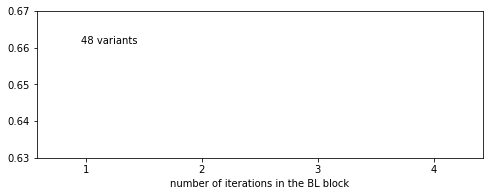

[0.4585538032181766, 0.4807022008889928, 0.49613435118804516, 0.5034115818107161] [4.8300543  3.21033485 1.46678629]


,num_of_cycles,performance,gain %
0,1,0.458554,NaN
1,2,0.480702,4.830054
2,3,0.496134,3.210335
3,4,0.503412,1.466786


In [11]:
plot_step_increase(corr_mean.xs(256, level='train_keep'), [(1,2),(2,3),(3,4),(2,4)], (0.63, 0.67))

In [12]:
# check relationship between num_param and performance, colored for different num_of_cycles.

training size 256


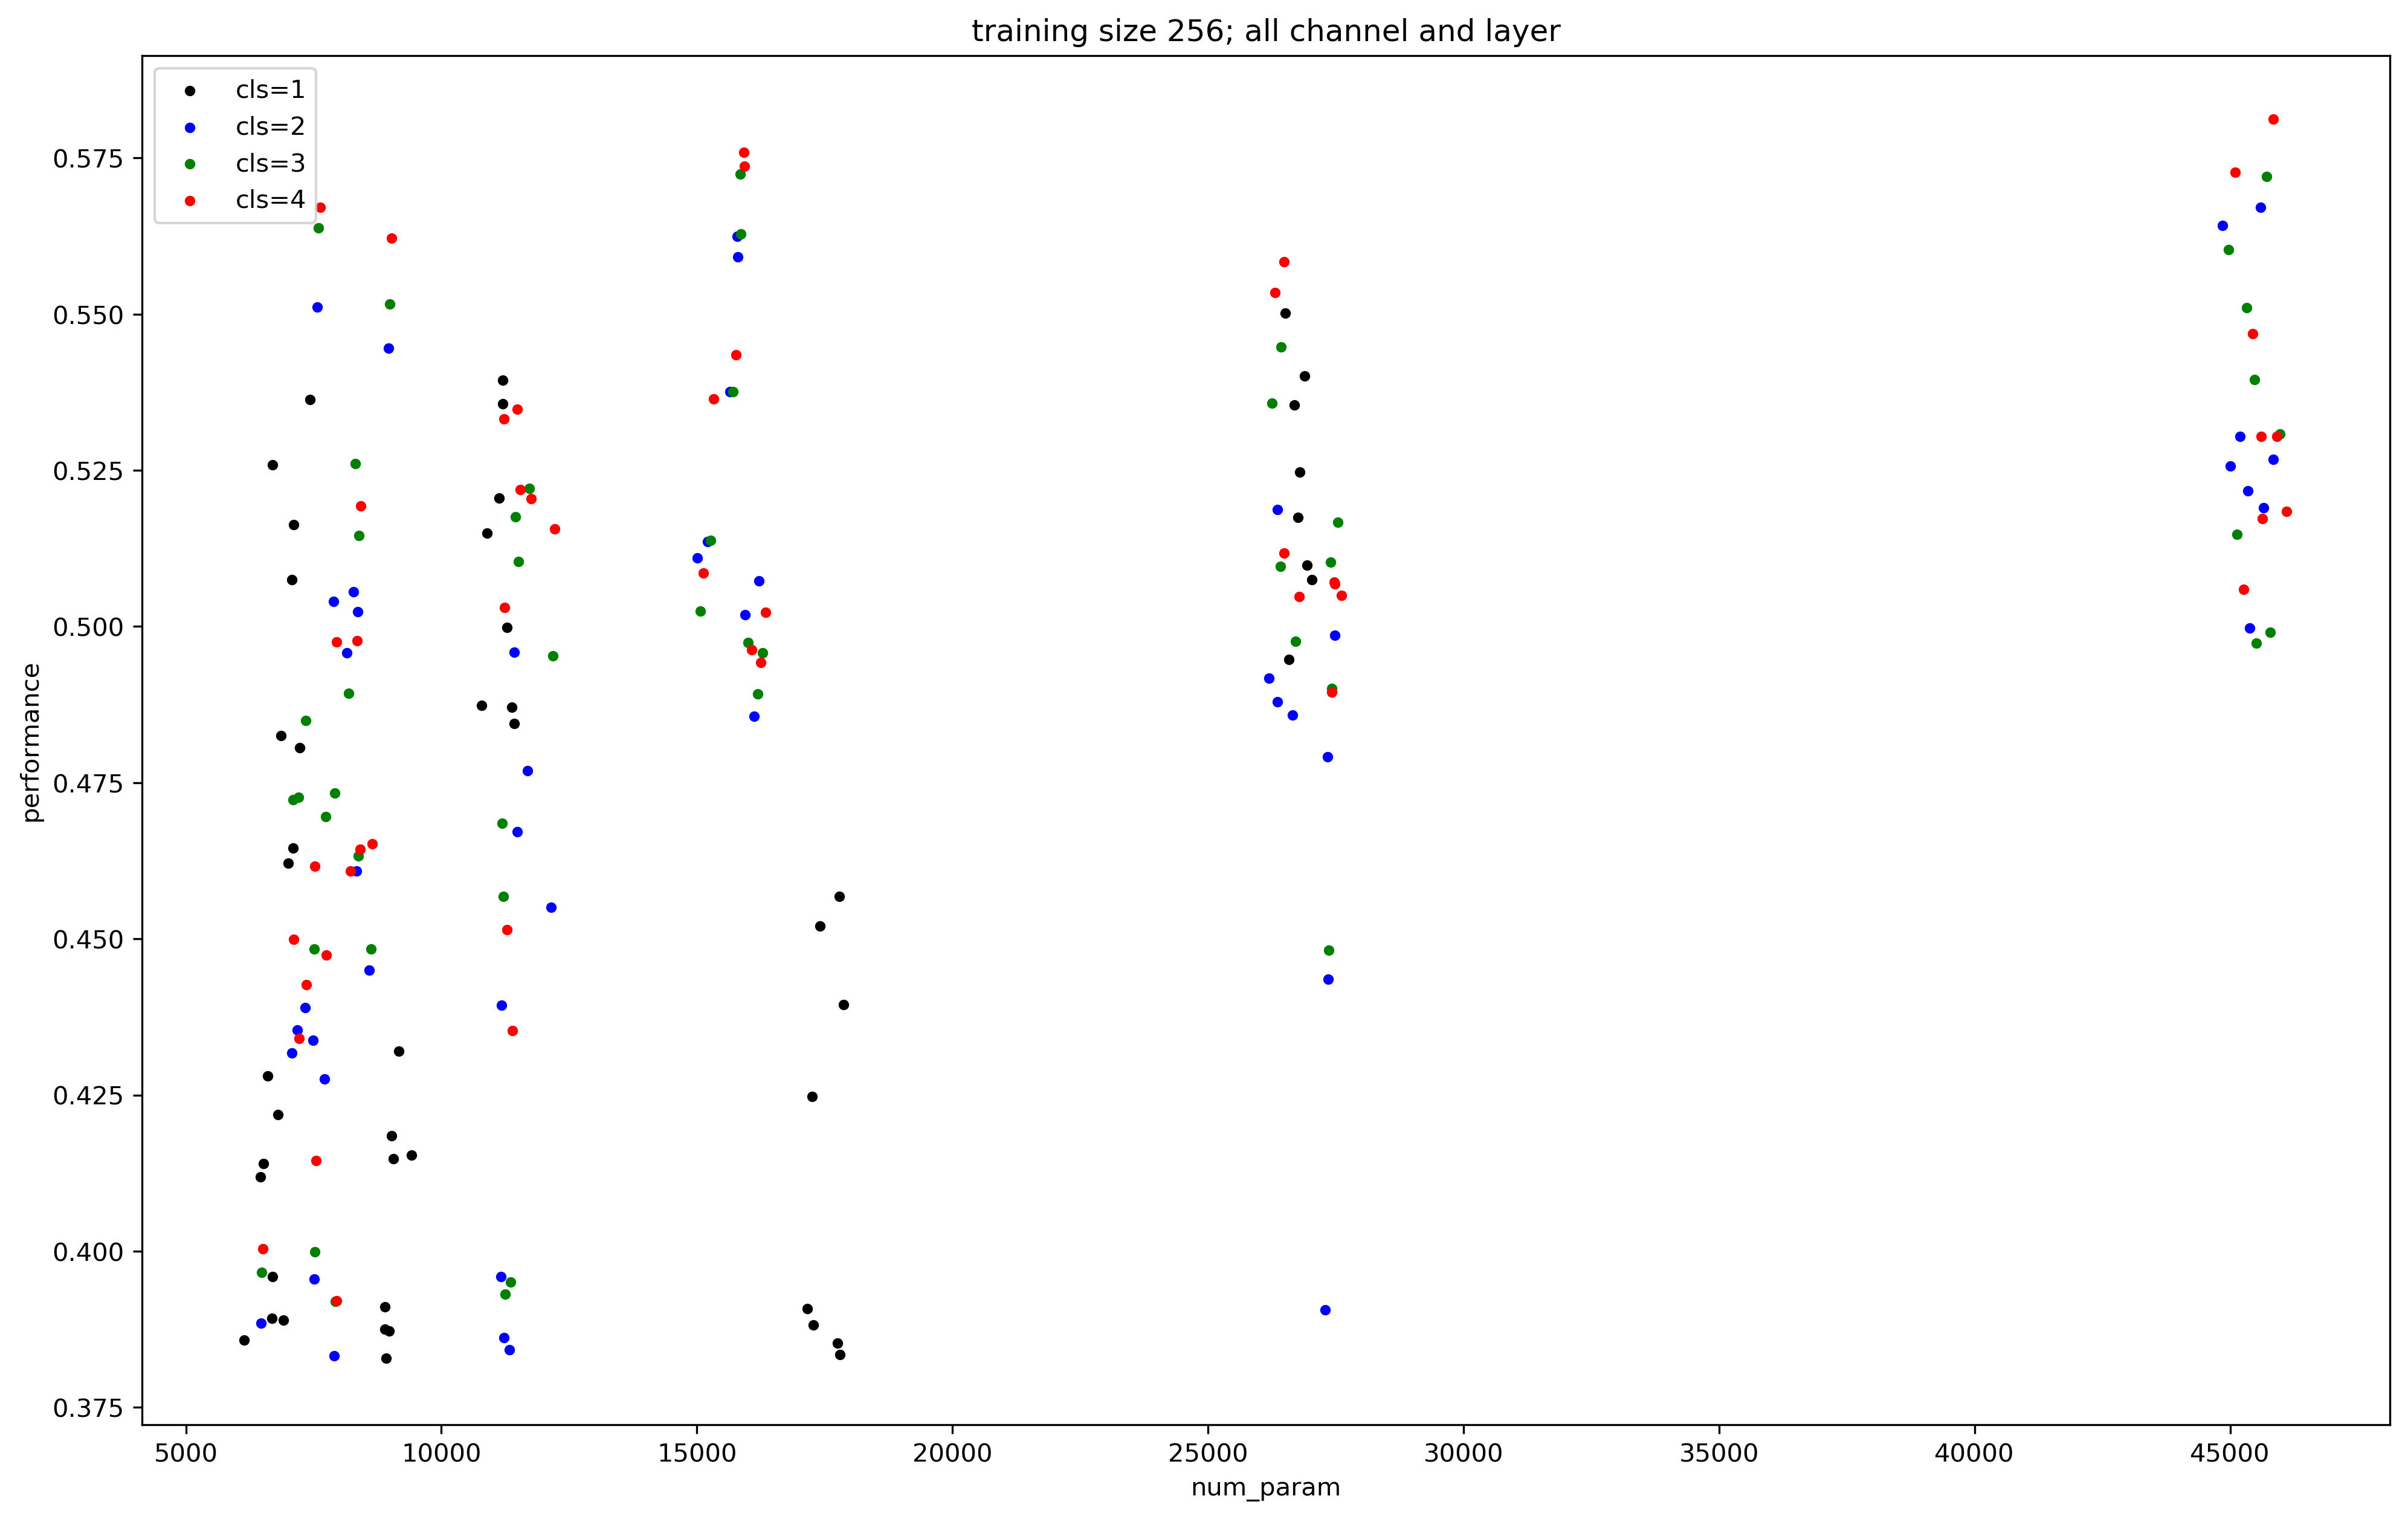

training size 475


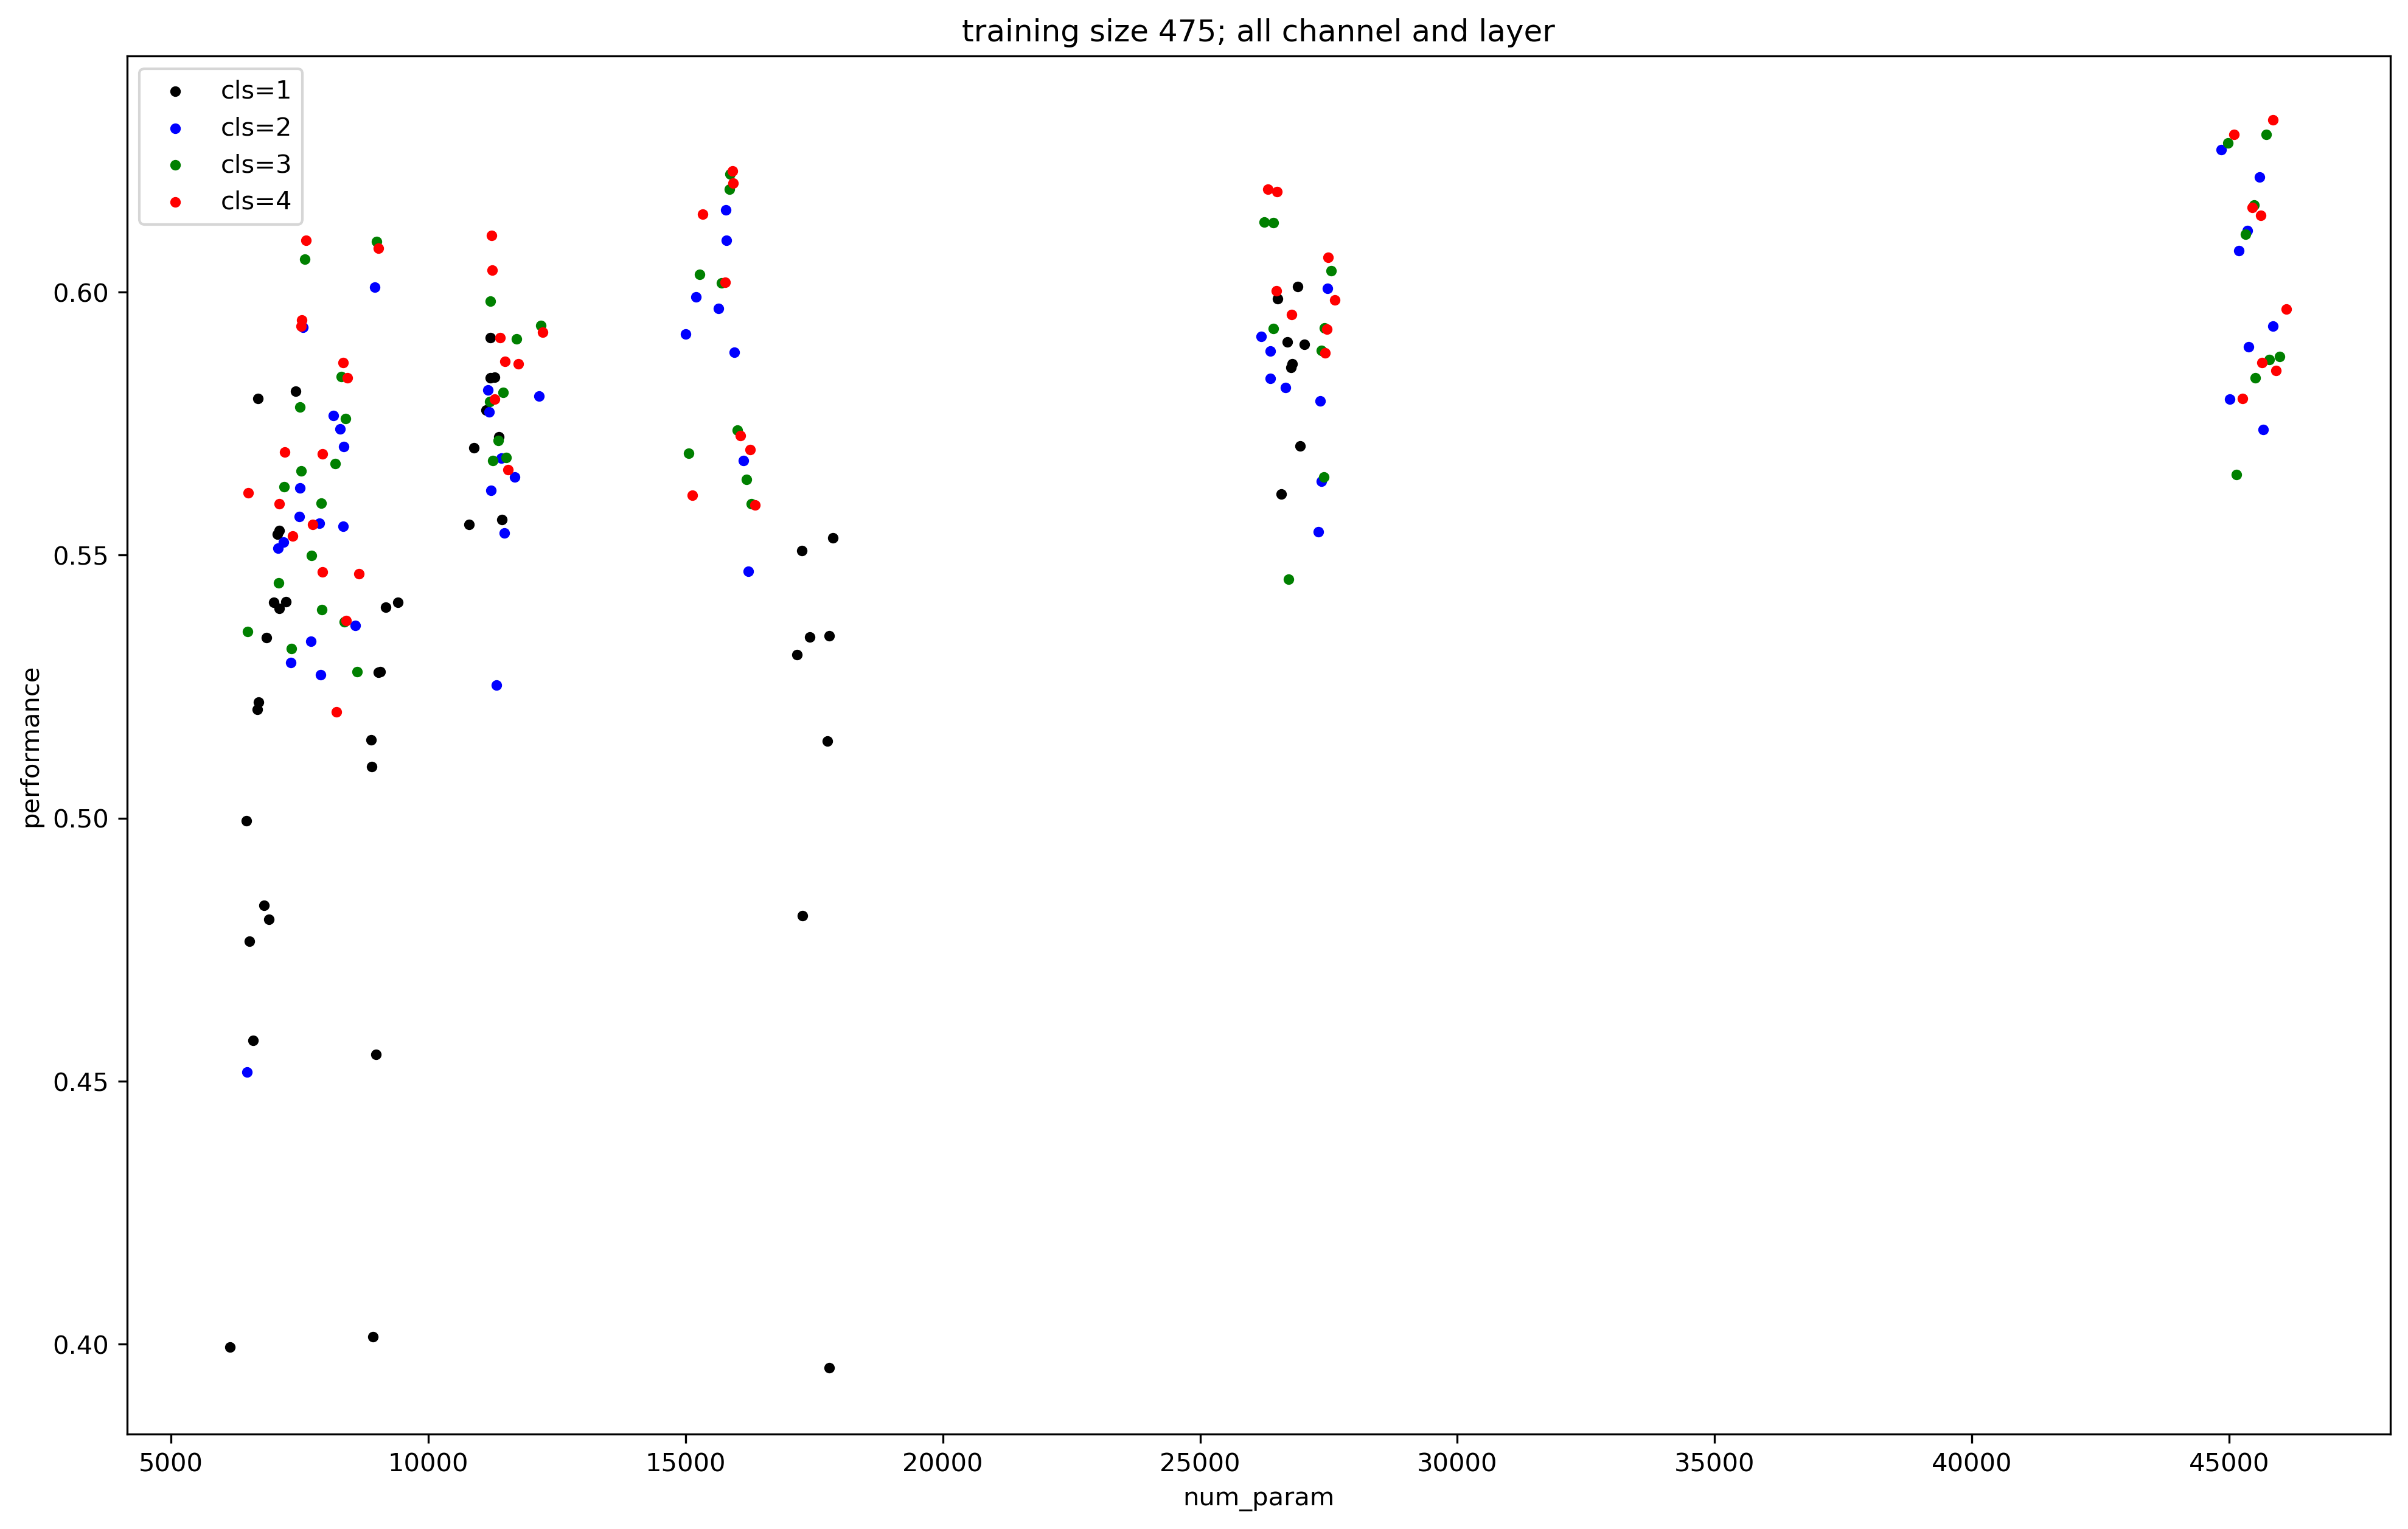

In [13]:
def check_relationship_between_num_param_and_perf_given_different_cycle(corr_mean_this, num_param_this, second_level, title_suffix):
    assert corr_mean_this.shape == num_param_this.shape
    assert corr_mean_this.index.equals(num_param_this.index)
    corr_mean_local = corr_mean_this.rename('corr_mean')
    num_param_local = num_param_this.rename('num_param')
    
    # combine them.
    df_to_check = pd.concat([corr_mean_local, num_param_local], axis=1)
    
    training_sizes = df_to_check.index.get_level_values('train_keep').unique()
    
    
    for training_size_this in training_sizes:
        print('training size', training_size_this)
        check_relationship_between_num_param_and_perf_given_different_cycle_inner(
            df_to_check.xs(training_size_this, level='train_keep'),
            title=f'training size {training_size_this}; {title_suffix}',
            second_level=second_level,
        )

def rand_jitter(arr, seed=0):
    rng_state = np.random.RandomState(seed=seed)
    stdev = .01*(max(arr)-min(arr))
    return arr + rng_state.randn(*arr.shape) * stdev
    return arr
        
def check_relationship_between_num_param_and_perf_given_different_cycle_inner(df_to_check, title, second_level):
    cycle_list = df_to_check.index.get_level_values('rcnn_bl_cls').unique()
    if second_level is not None:
        layer_list = df_to_check.index.get_level_values(second_level).unique()
    else:
        layer_list = [None]
    color_list = ['k', 'b', 'g', 'r']
    marker_list = ['o', 'D', '*']
    assert len(color_list) >= len(cycle_list)
    assert len(marker_list) >= len(layer_list)
    plt.close('all')
    plt.figure(figsize=(16, 10), dpi=300)
    
    for c, color in zip(cycle_list, color_list):
        for num_l, marker in zip(layer_list, marker_list):
            data_this = df_to_check.xs(c, level='rcnn_bl_cls')
            if second_level is not None:
                data_this=data_this.xs(num_l, level=second_level)
            plt.scatter(
                # jitter num_param so that I can tell dots apart
                rand_jitter(data_this['num_param'].values),
                data_this['corr_mean'].values,
                s=10,
                marker=marker,
                c=color,
                label=f'cls={c}, {second_level}={num_l}' if second_level is not None else f'cls={c}',
            )
    
    plt.legend(loc='best')
#     plt.xlim(0,1)
#     plt.ylim(0,1)
#     plt.plot([0,1],[0,1],linestyle='--')
    plt.title(title)
    plt.xlabel('num_param')
    plt.ylabel('performance')
    
    
    plt.show()

check_relationship_between_num_param_and_perf_given_different_cycle(corr_mean, num_param,
                                                                   second_level=None, title_suffix='all channel and layer')
# with similar number of parameters, I think definitely more cycles can lead to better results.

training size 256


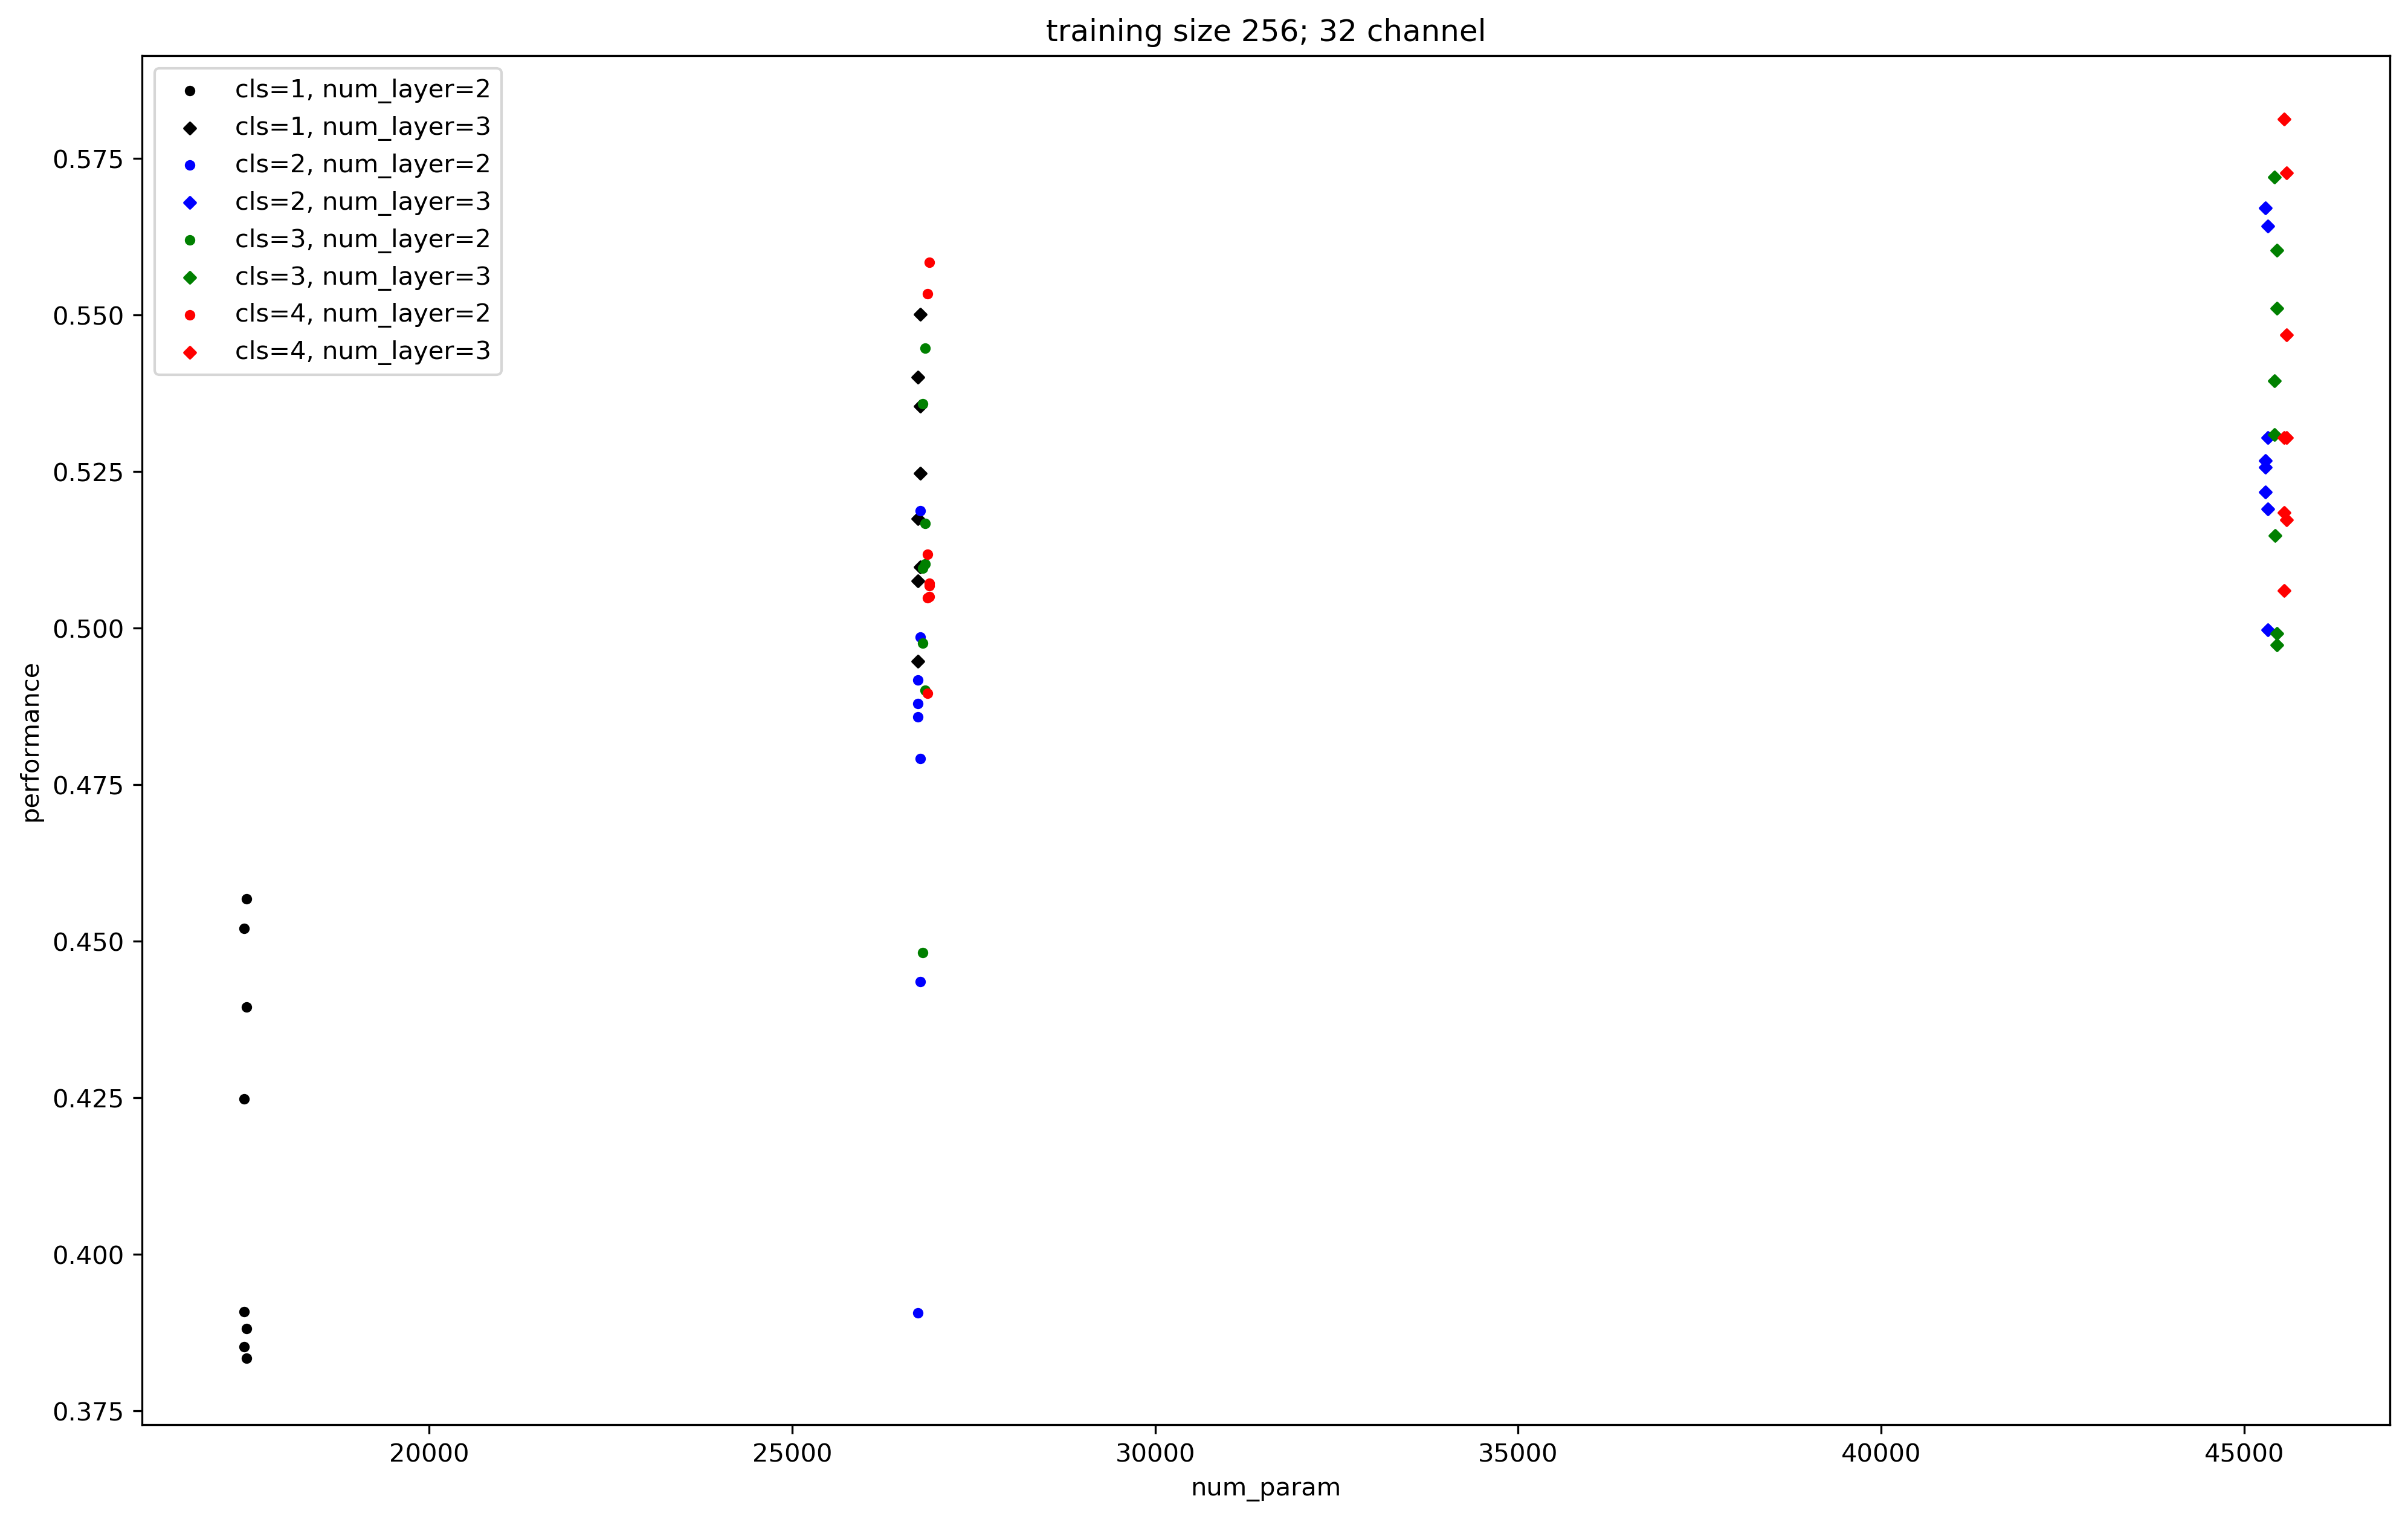

training size 475


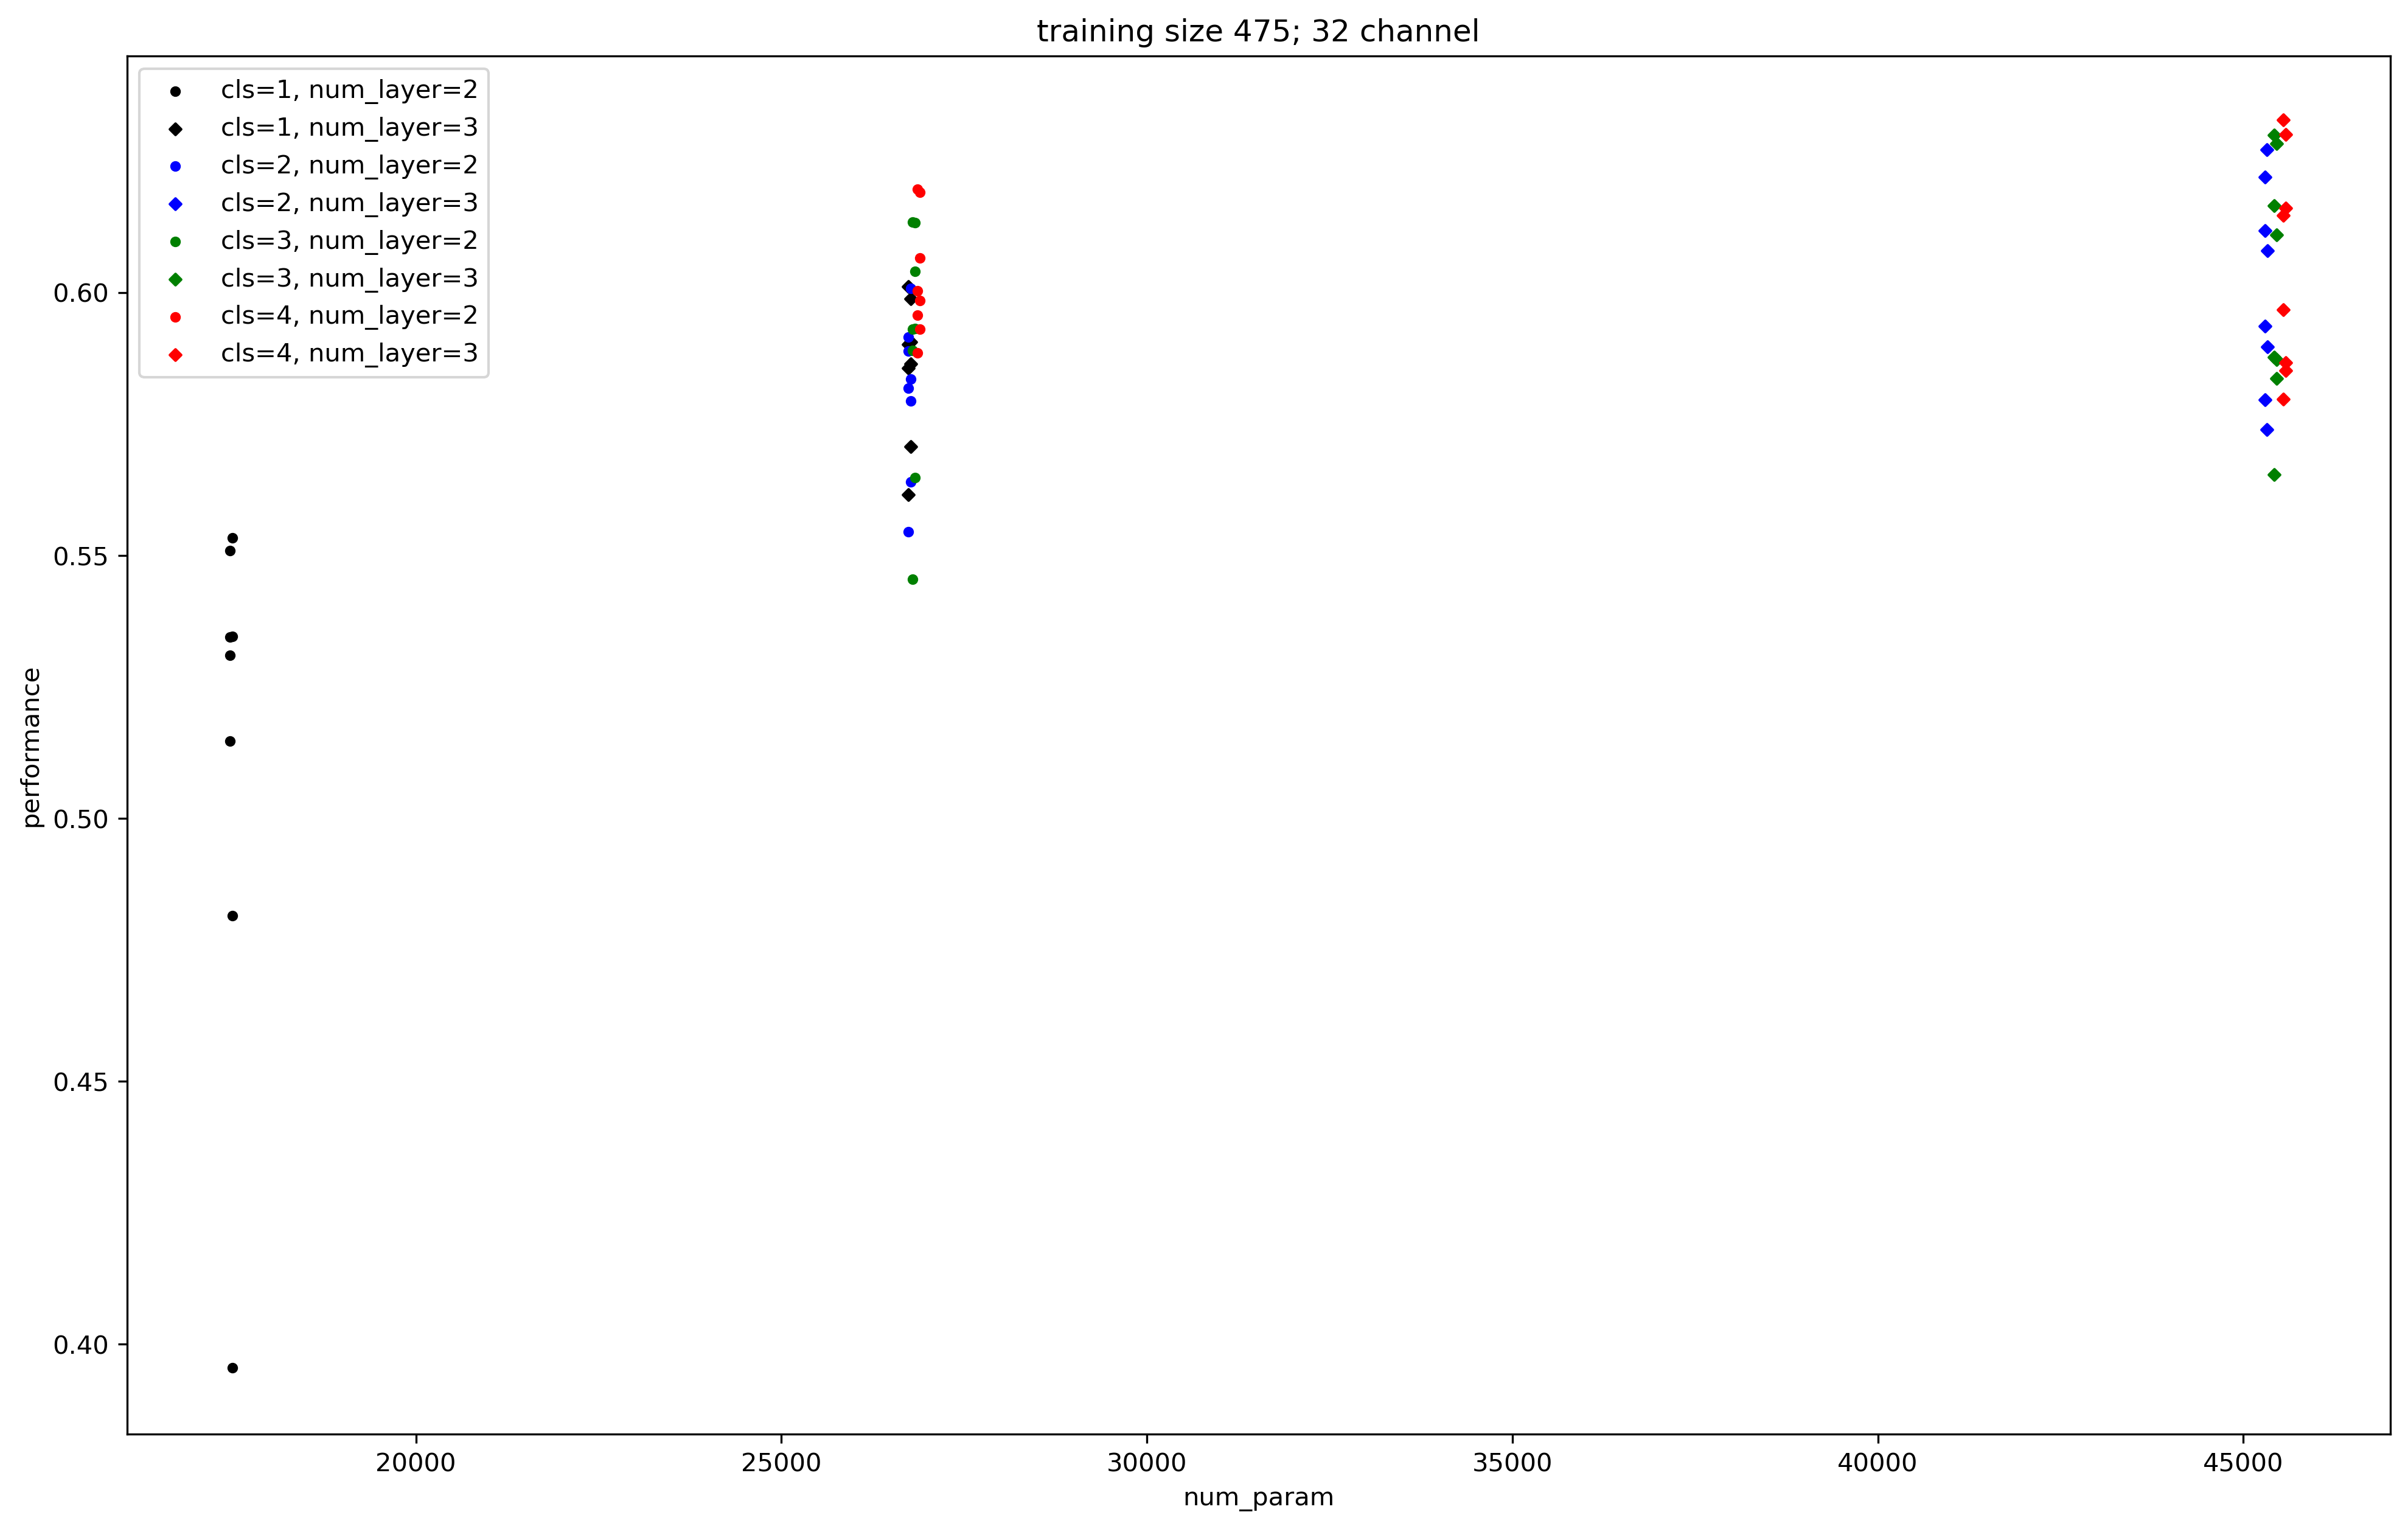

In [14]:
check_relationship_between_num_param_and_perf_given_different_cycle(
    corr_mean.xs(32, level='out_channel'),
    num_param.xs(32, level='out_channel'),
    second_level='num_layer',
    title_suffix='32 channel'
)

training size 256


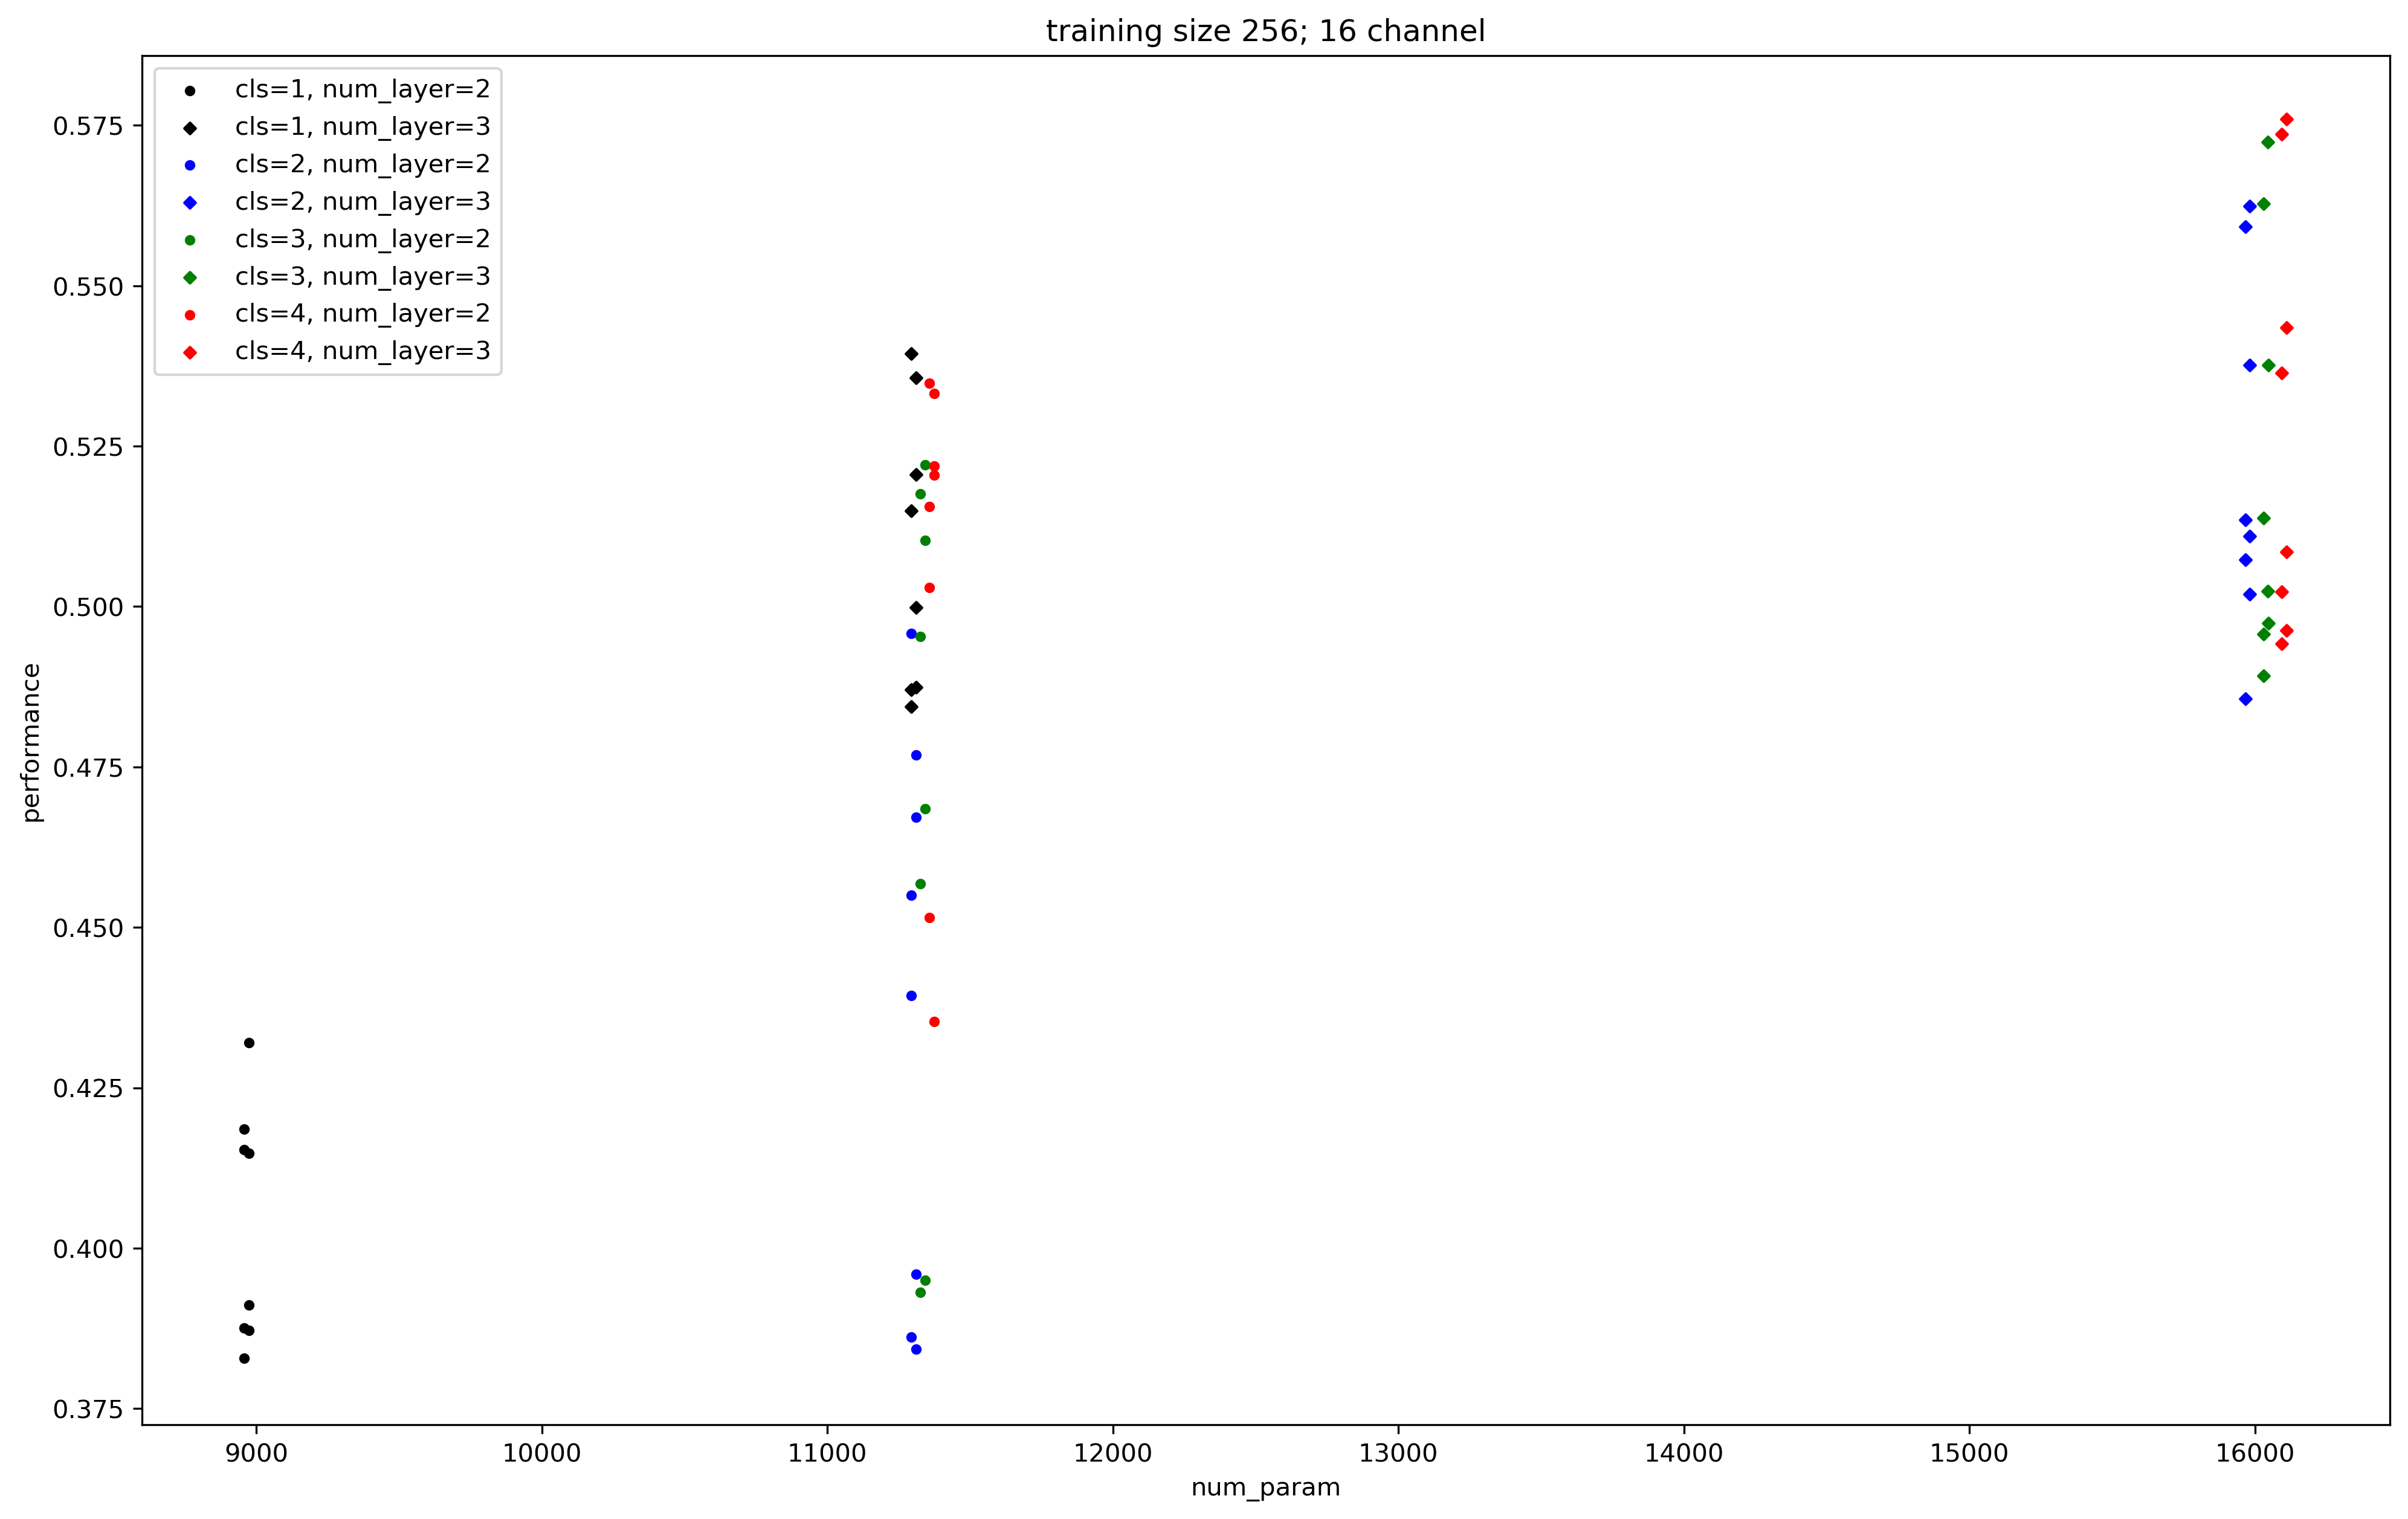

training size 475


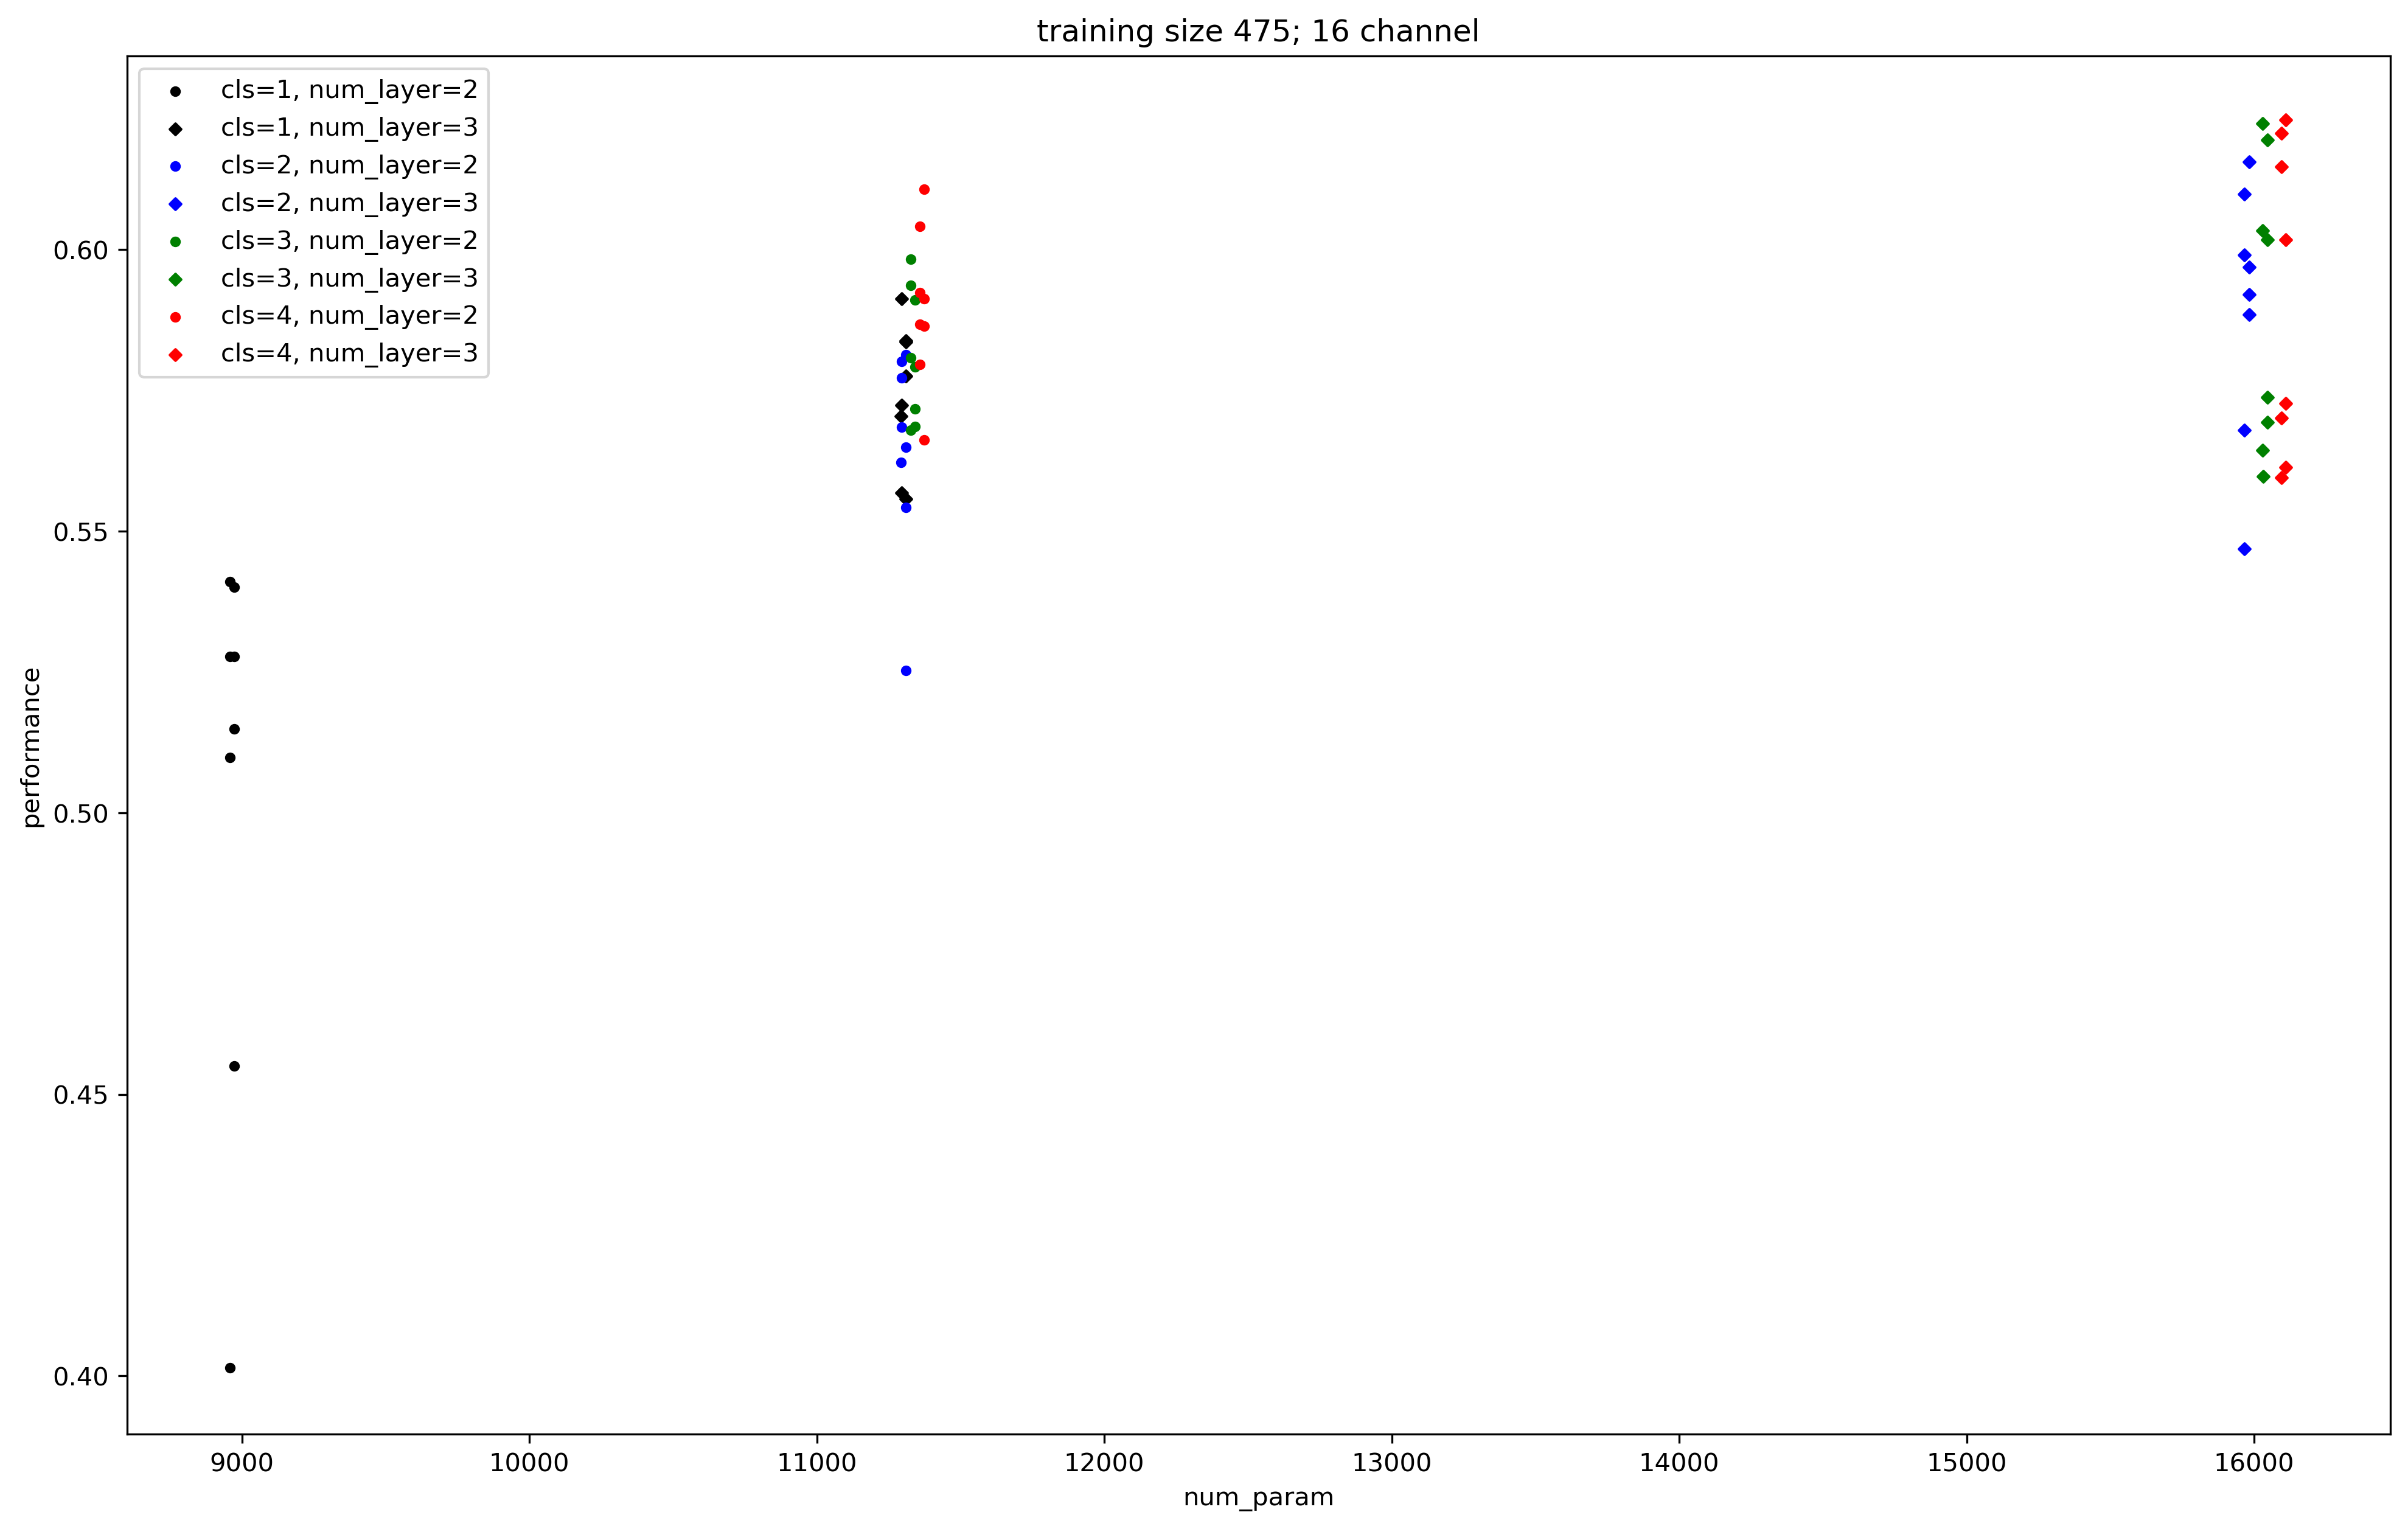

In [15]:
check_relationship_between_num_param_and_perf_given_different_cycle(
    corr_mean.xs(16, level='out_channel'),
    num_param.xs(16, level='out_channel'),
    second_level='num_layer',
    title_suffix='16 channel'
)

training size 256


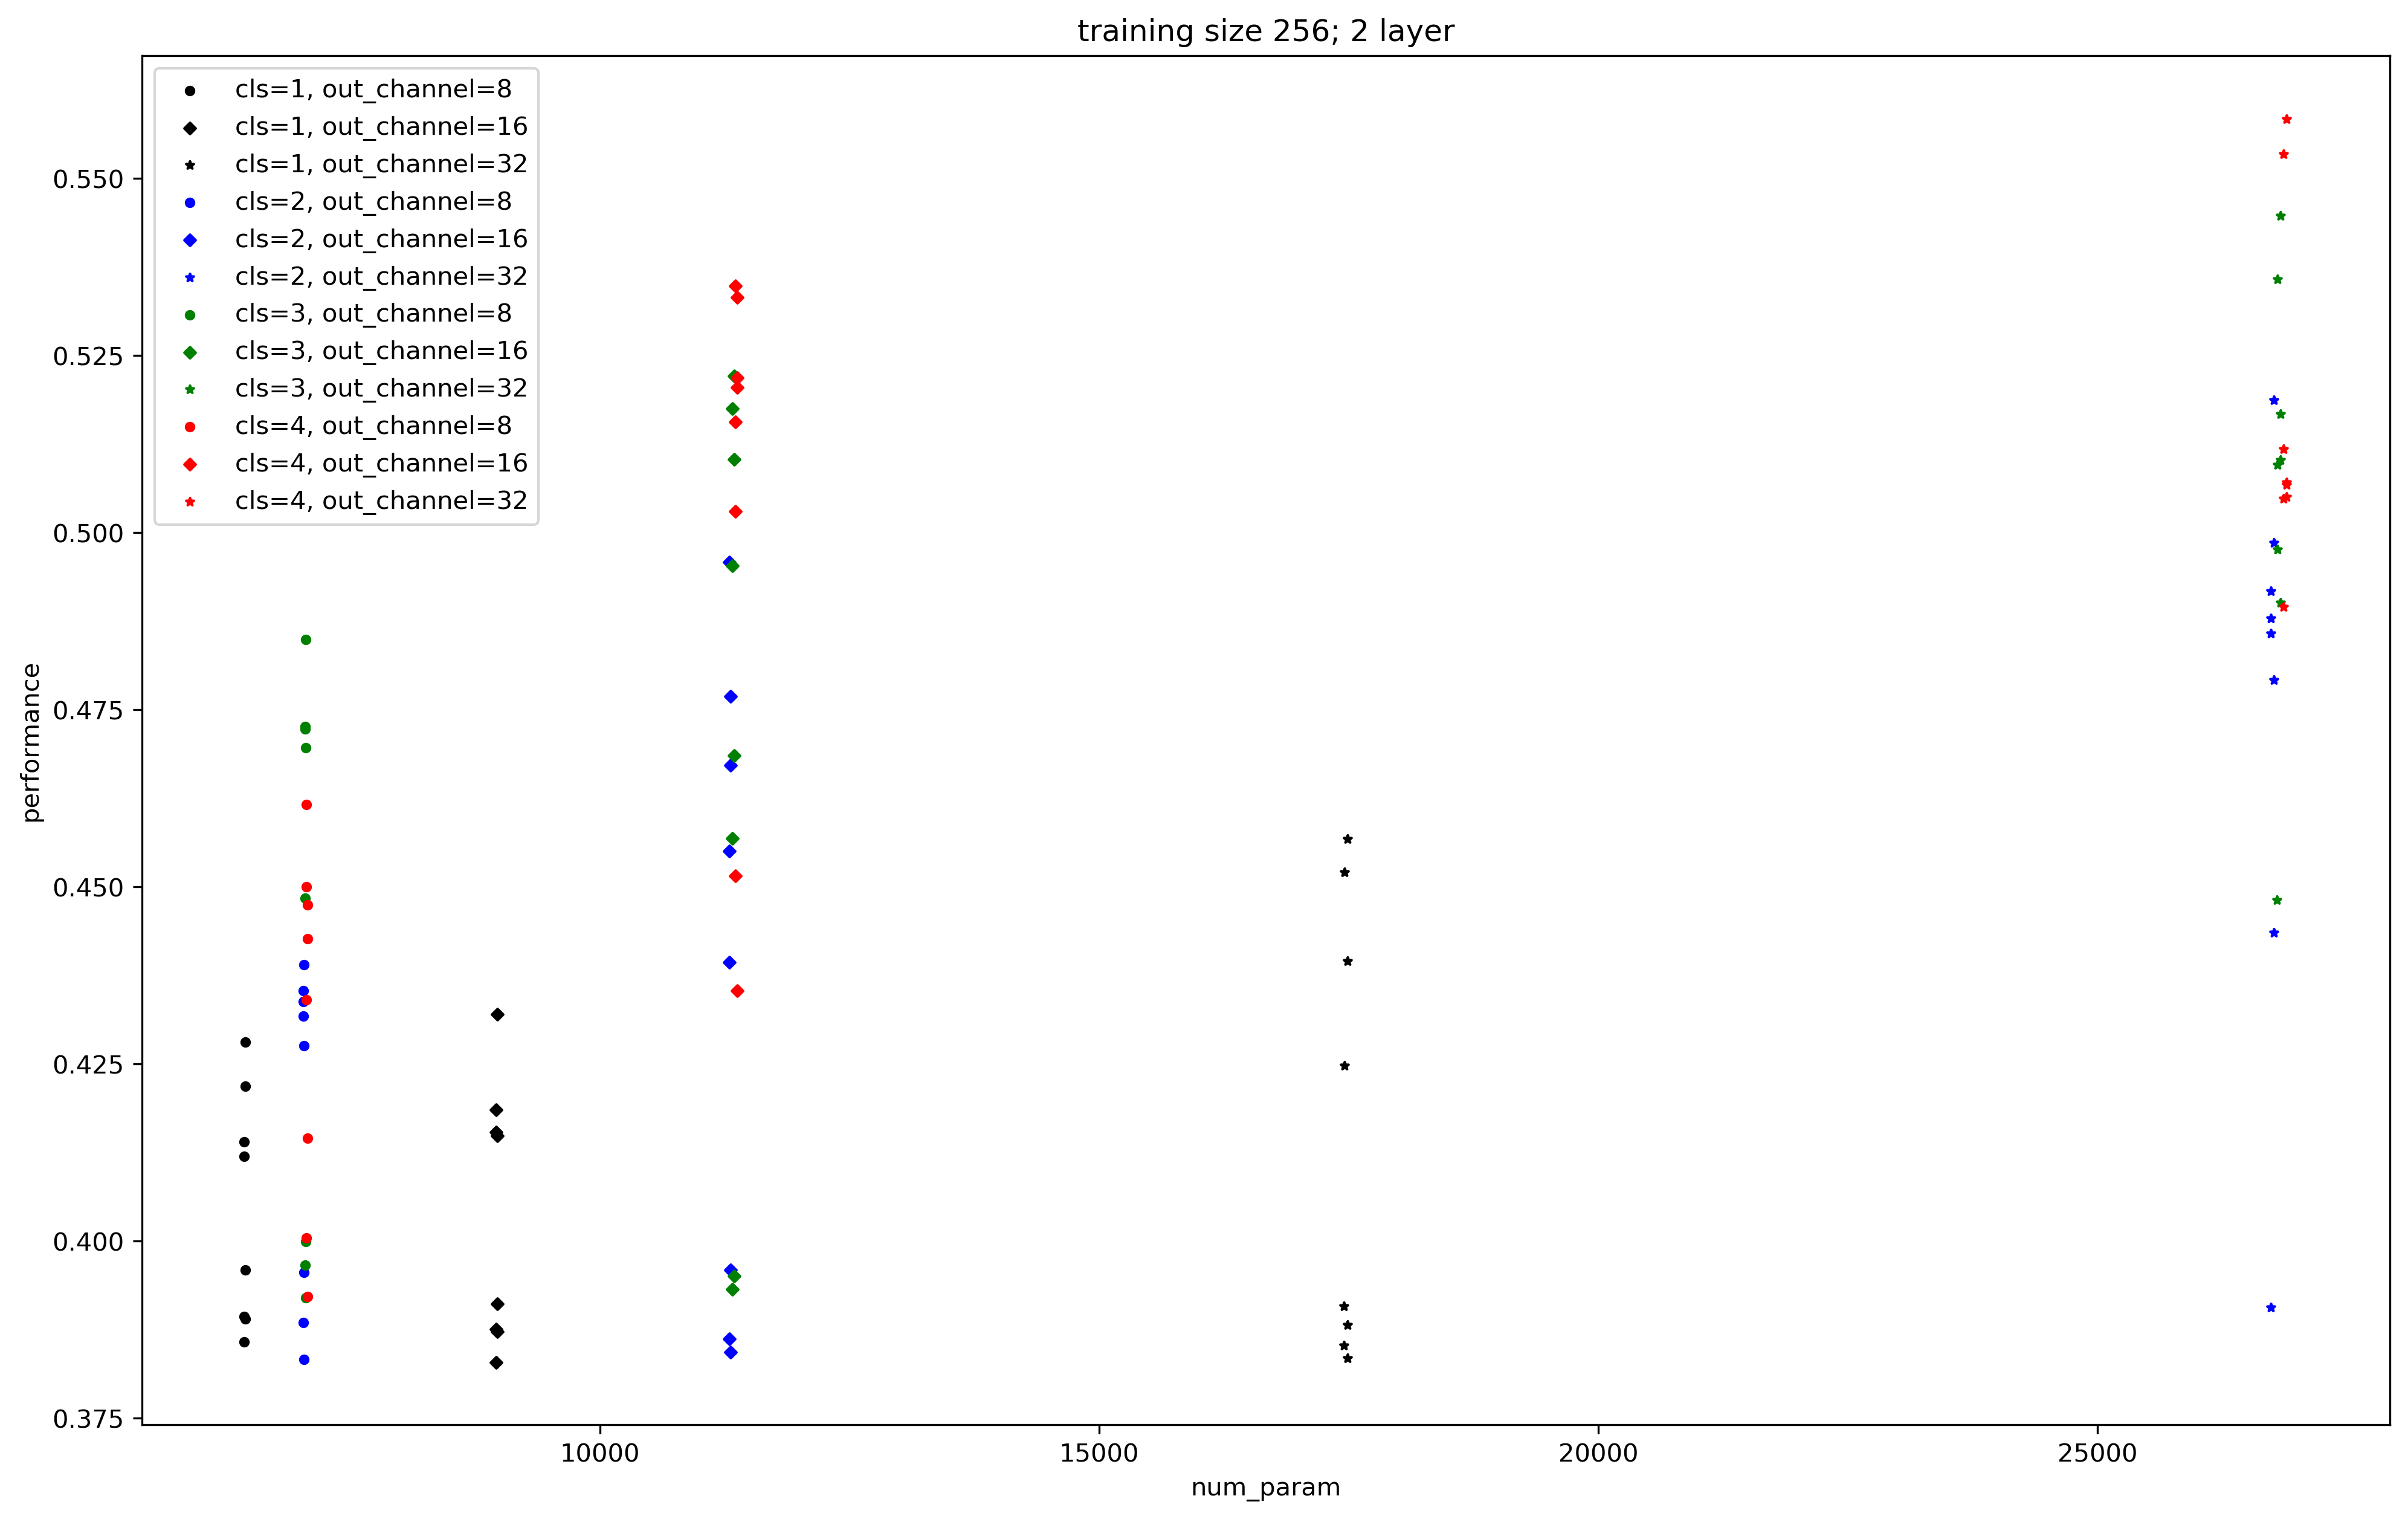

training size 475


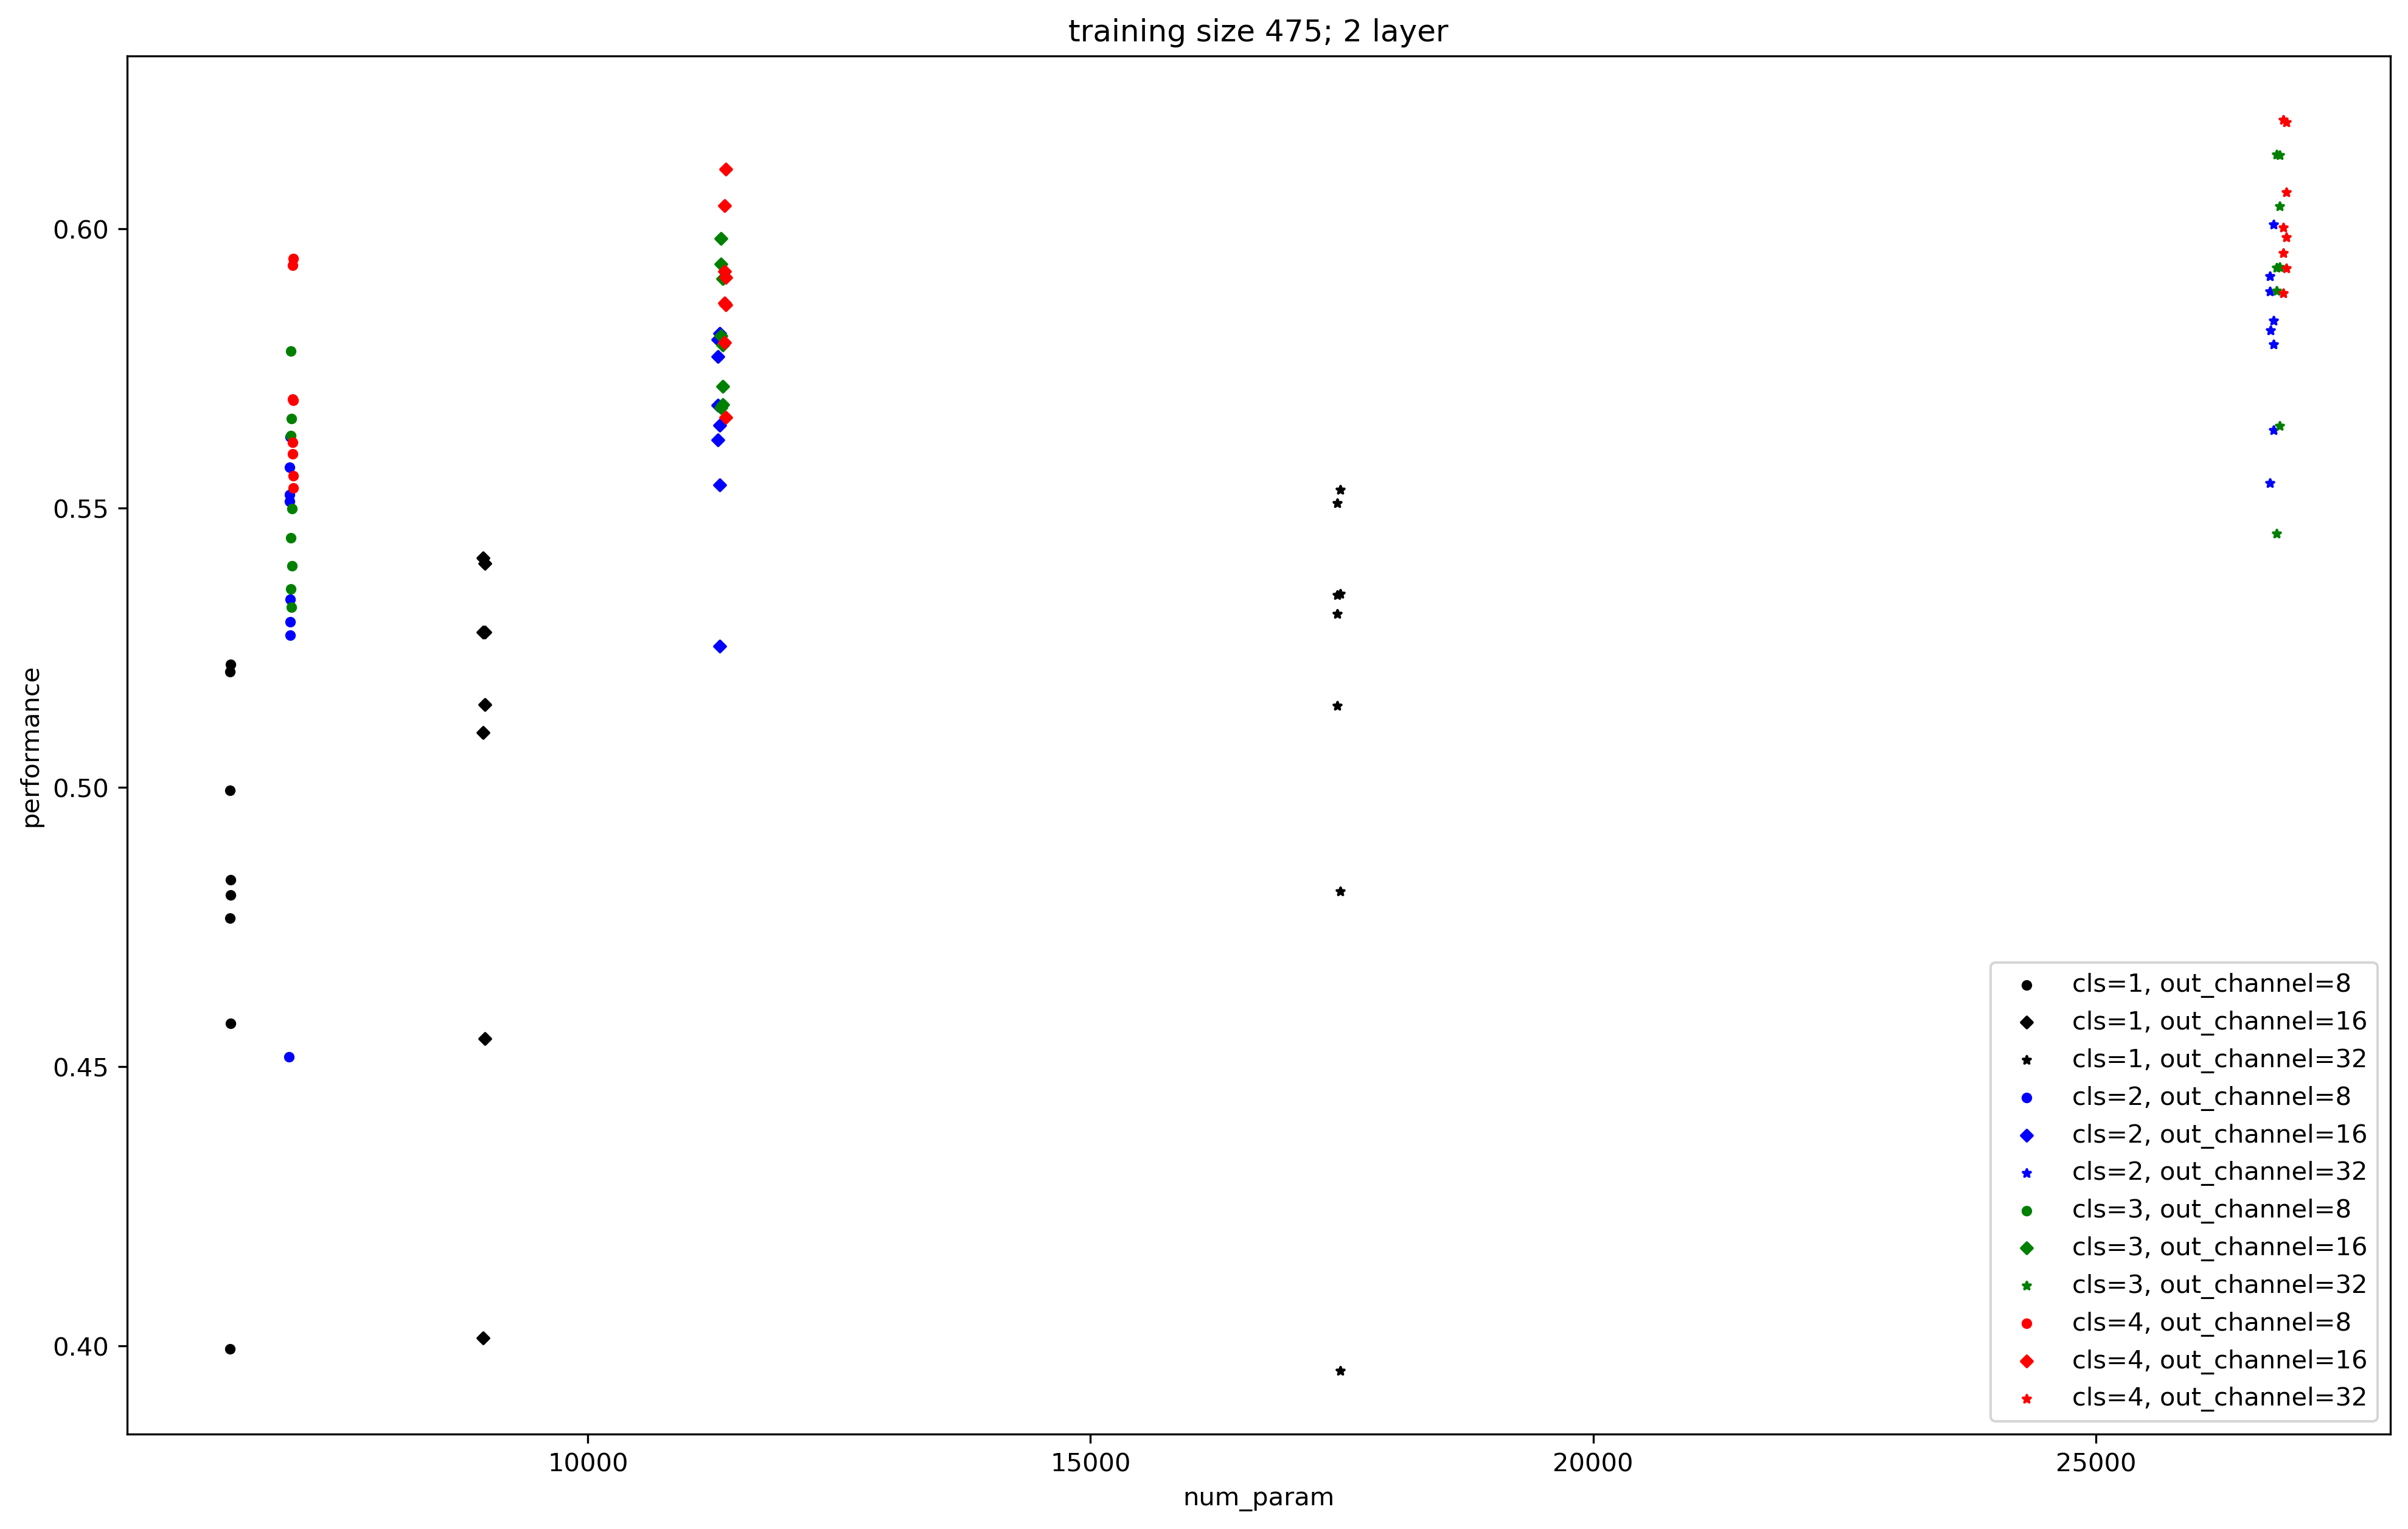

In [16]:
check_relationship_between_num_param_and_perf_given_different_cycle(
    corr_mean.xs(2, level='num_layer'),
    num_param.xs(2, level='num_layer'),
    second_level='out_channel',
    title_suffix='2 layer'
)

training size 256


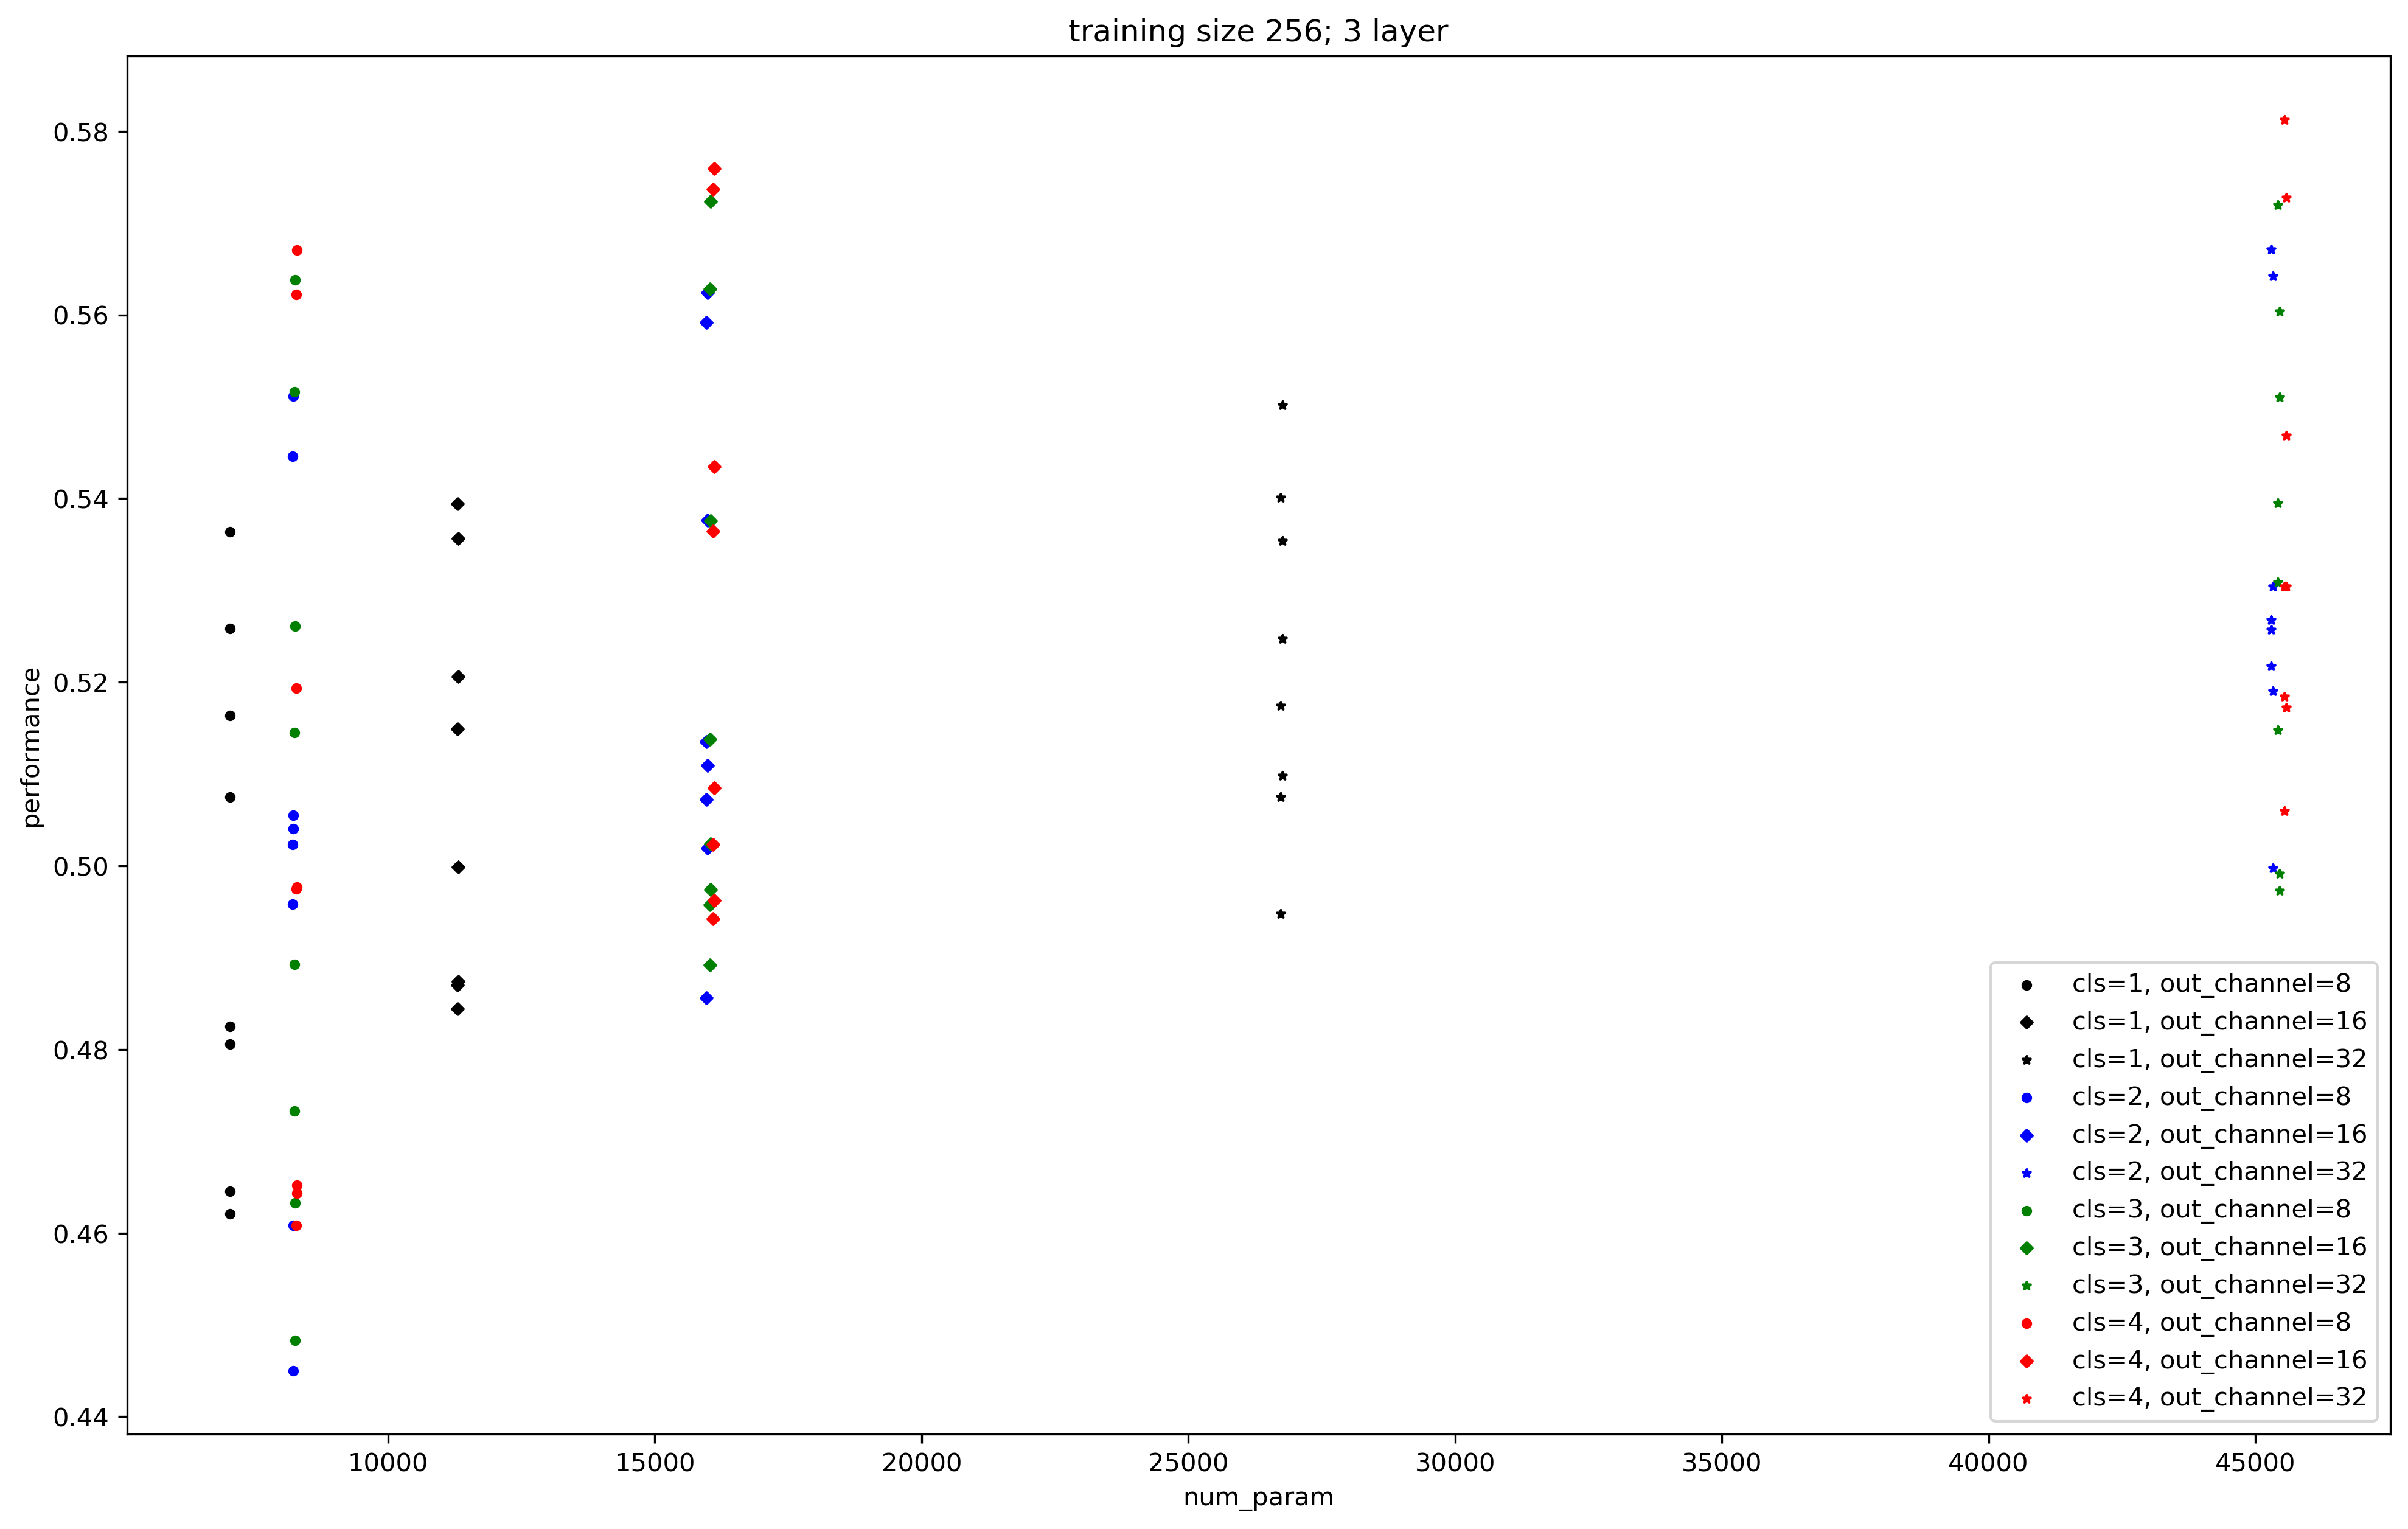

training size 475


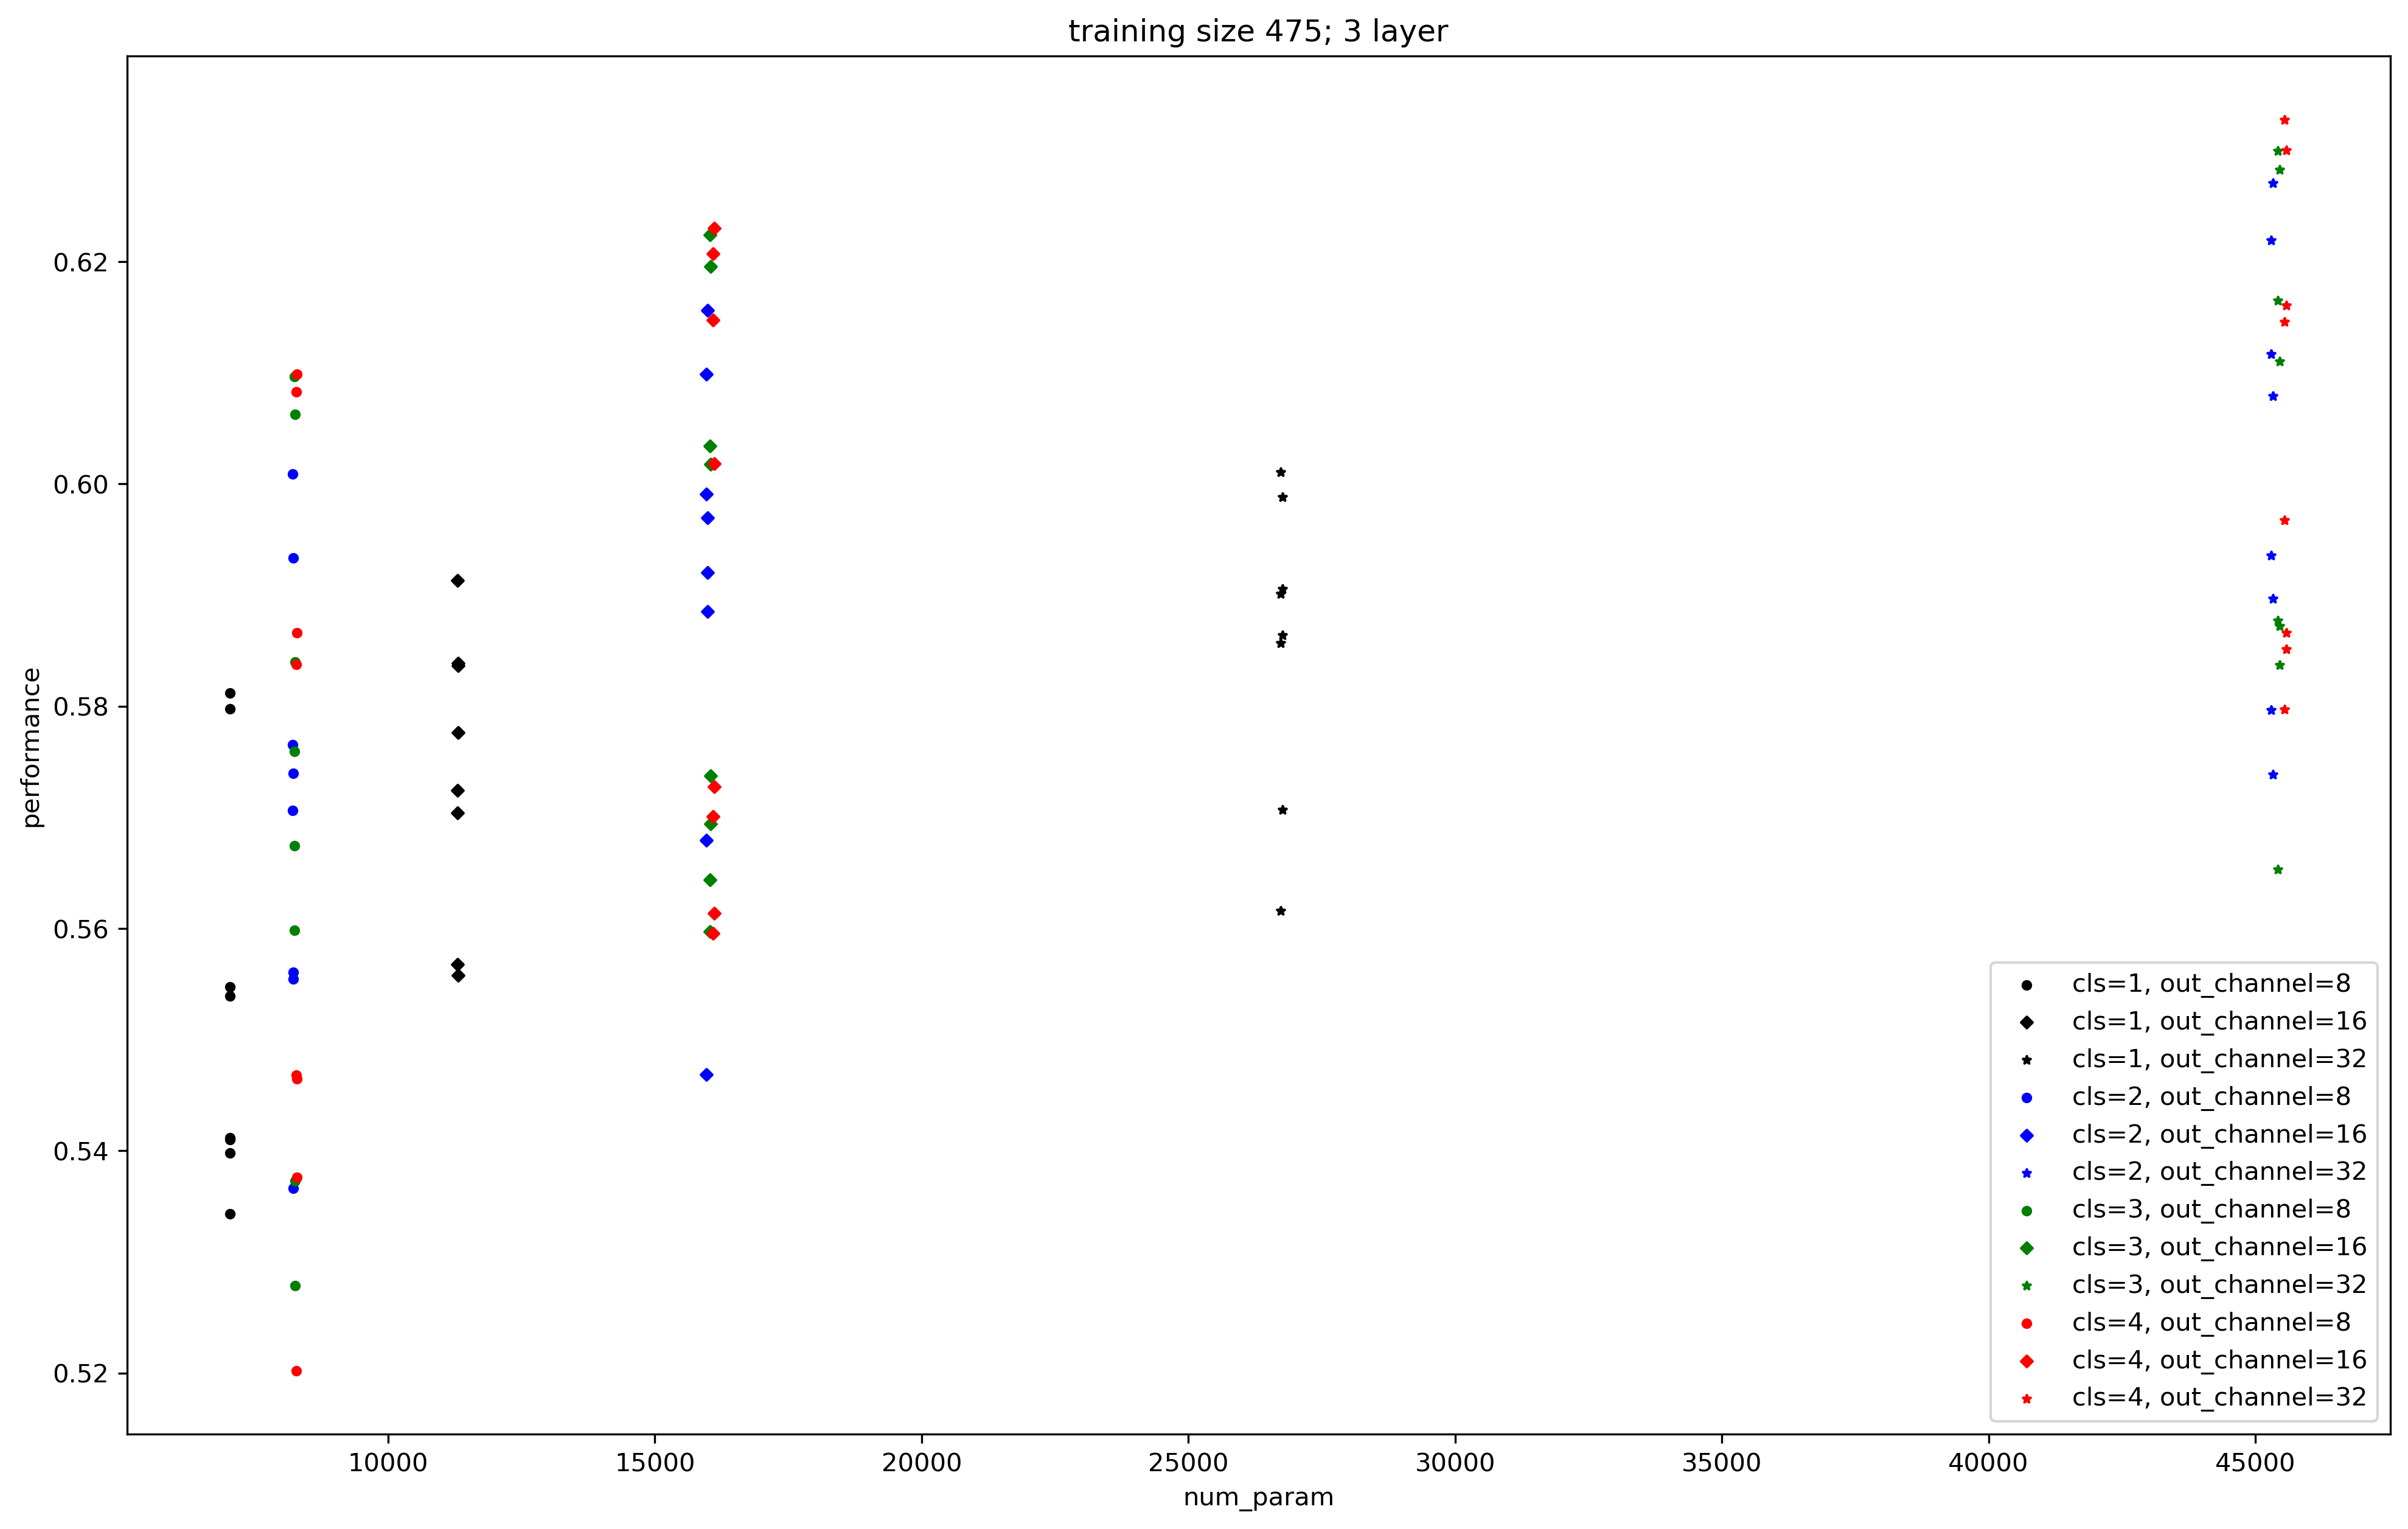

In [17]:
check_relationship_between_num_param_and_perf_given_different_cycle(
    corr_mean.xs(3, level='num_layer'),
    num_param.xs(3, level='num_layer'),
    second_level='out_channel',
    title_suffix='3 layer'
)